In [1]:
import pandas as pd
import numpy as np
import warnings
import pickle
import os
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from boruta import BorutaPy
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import shap

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Load processed data if it exists (skip Boruta after kernel restart)
if os.path.exists('processed_data.pkl'):
    with open('processed_data.pkl', 'rb') as f:
        saved_data = pickle.load(f)
        df_selected = saved_data['df_selected']
        train_df = saved_data['train_df']
        test_df = saved_data['test_df']
        scaler = saved_data['scaler']
    print("Loaded saved processed data - you can skip to model training!")

# Load SMILES data (tab-separated)
smiles_df = pd.read_csv(
    '/Users/tjalling/Desktop/Dev./Capstone/Datasets/Kinetics Model /Svatunek Dataset/SMILES.txt',
    sep='\t',
    names=['tetrazine_id', 'group', 'subgroup', 'smiles']
)

# Load barriers data (comma-separated)
barriers_df = pd.read_csv(
    '/Users/tjalling/Desktop/Dev./Capstone/Datasets/Kinetics Model /Svatunek Dataset/barriers.csv'
)

# Merge on tetrazine ID
merged_df = pd.merge(
    smiles_df[['tetrazine_id', 'smiles']],
    barriers_df[['tetrazine', 'freeEnergy']],
    left_on='tetrazine_id',
    right_on='tetrazine',
    how='inner'
)

# Clean up: keep only relevant columns and rename
df = merged_df[['smiles', 'freeEnergy']].copy()
df.rename(columns={'freeEnergy': 'delta_g'}, inplace=True)

ImportError: cannot import name 'product' from 'numpy' (/Users/tjalling/.pyenv/versions/3.11.7/lib/python3.11/site-packages/numpy/__init__.py)

In [3]:
def add_rdkit_descriptors(df, smiles_column='smiles'):
    """
    Add RDKit molecular descriptors to dataframe from SMILES strings.
    
    Args:
        df: DataFrame containing SMILES strings
        smiles_column: Name of column containing SMILES strings
        
    Returns:
        DataFrame with RDKit descriptors added
    """
    chosen_descriptors = [
        'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v',
        'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1',
        'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4',
        'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9',
        'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
        'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc',
        'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex',
        'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex',
        'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP',
        'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
        'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles',
        'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors',
        'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles',
        'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1',
        'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2',
        'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8',
        'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3',
        'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9',
        'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2',
        'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7',
        'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10',
        'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6',
        'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH',
        'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH',
        'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S',
        'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O',
        'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH',
        'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid',
        'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide',
        'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic',
        'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether',
        'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone',
        'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone',
        'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine',
        'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho',
        'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation',
        'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester',
        'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd',
        'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
        'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan',
        'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed'
    ]
    
    all_descriptors = []
    failed_smiles = []
    
    for idx, smiles in enumerate(df[smiles_column]):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                desc_values = []
                for desc_name in chosen_descriptors:
                    try:
                        desc_func = getattr(Descriptors, desc_name)
                        desc_values.append(desc_func(mol))
                    except:
                        desc_values.append(np.nan)
                all_descriptors.append(desc_values)
            else:
                print(f"Invalid SMILES at index {idx}: {smiles}")
                all_descriptors.append([np.nan] * len(chosen_descriptors))
                failed_smiles.append(idx)
        except Exception as e:
            print(f"Error processing SMILES at index {idx}: {smiles}, Error: {e}")
            all_descriptors.append([np.nan] * len(chosen_descriptors))
            failed_smiles.append(idx)
    
    descriptors_df = pd.DataFrame(all_descriptors, columns=chosen_descriptors)
    result_df = pd.concat([df.reset_index(drop=True), descriptors_df], axis=1)
    
    if failed_smiles:
        print(f"Failed to process {len(failed_smiles)} SMILES")
    
    return result_df


def add_mordred_descriptors(df, smiles_column='smiles'):
    """
    Add Mordred descriptors to dataframe from SMILES strings.
    
    Args:
        df: DataFrame containing SMILES strings
        smiles_column: Name of column containing SMILES strings
        
    Returns:
        DataFrame with Mordred descriptors added
    """
    calc = Calculator(descriptors, ignore_3D=True)
    mordred_features = []
    failed_indices = []
    
    for idx, smiles in enumerate(df[smiles_column]):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            try:
                desc = calc(mol)
                mordred_features.append(list(desc))
            except Exception as e:
                print(f"Error at index {idx}: {e}")
                mordred_features.append([None] * len(calc.descriptors))
                failed_indices.append(idx)
        else:
            print(f"Invalid SMILES at index {idx}: {smiles}")
            mordred_features.append([None] * len(calc.descriptors))
            failed_indices.append(idx)
    
    mordred_df = pd.DataFrame(mordred_features, columns=[str(d) for d in calc.descriptors])
    mordred_df.index = df.index
    df_with_mordred = pd.concat([df, mordred_df], axis=1)
    
    return df_with_mordred


def remove_duplicate_columns(df):
    """
    Remove duplicate column names, keeping first occurrence.
    
    Args:
        df: DataFrame with potential duplicate columns
        
    Returns:
        DataFrame with duplicate columns removed
    """
    return df.loc[:, ~df.columns.duplicated()]


# Add RDKit descriptors
df_with_rdkit = add_rdkit_descriptors(df, smiles_column='smiles')

# Add Mordred descriptors
df_with_all_descriptors = add_mordred_descriptors(df_with_rdkit, smiles_column='smiles')

# Remove any duplicate columns
final_df = remove_duplicate_columns(df_with_all_descriptors)

# Remove columns with all NaN values
final_df = final_df.dropna(axis=1, how='all')

print(f"Final dataset: {final_df.shape[0]} molecules, {final_df.shape[1] - 2} total features")
print(f"\n{final_df.head()}")

KeyboardInterrupt: 

In [30]:
def clean_and_normalize_data(df, target_column='delta_g', col_nan_threshold=0.05, row_nan_threshold=0.05):
    """
    Clean and normalize molecular descriptor data (conservative academic approach).
    
    Args:
        df: DataFrame with molecular descriptors
        target_column: Target column name
        col_nan_threshold: Remove columns with NaN proportion above this
        row_nan_threshold: Remove rows with NaN proportion above this
        
    Returns:
        Tuple of (cleaned and normalized DataFrame, fitted scaler)
    """
    df_clean = df.copy()
    feature_cols = [col for col in df_clean.columns if col not in ['smiles', target_column]]
    initial_rows = len(df_clean)
    
    # Convert to numeric (Mordred creates error objects)
    for col in feature_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Replace infinite values with NaN
    df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Step 1: Remove columns with >5% NaN or constant values
    cols_high_nan = []
    cols_constant = []
    for col in feature_cols:
        nan_prop = df_clean[col].isna().sum() / len(df_clean)
        if nan_prop > col_nan_threshold:
            cols_high_nan.append(col)
        elif df_clean[col].nunique() <= 1:
            cols_constant.append(col)
    
    df_clean = df_clean.drop(columns=cols_high_nan + cols_constant)
    
    # Step 2: Remove rows with >5% NaN in remaining features
    feature_cols = [col for col in df_clean.columns if col not in ['smiles', target_column]]
    row_nan_props = df_clean[feature_cols].isna().sum(axis=1) / len(feature_cols)
    rows_to_keep = row_nan_props <= row_nan_threshold
    df_clean = df_clean[rows_to_keep].reset_index(drop=True)
    rows_removed = initial_rows - len(df_clean)
    
    # Step 3: Remove any remaining columns with NaN or zero variance
    cols_with_nan = []
    cols_zero_var = []
    for col in feature_cols:
        if col in df_clean.columns:
            if df_clean[col].isna().any():
                cols_with_nan.append(col)
            elif df_clean[col].std() == 0:
                cols_zero_var.append(col)
    
    df_clean = df_clean.drop(columns=cols_with_nan + cols_zero_var)
    feature_cols = [col for col in df_clean.columns if col not in ['smiles', target_column]]
    
    # Step 4: Normalize features
    scaler = StandardScaler()
    df_clean[feature_cols] = scaler.fit_transform(df_clean[feature_cols])
    
    # Step 5: Remove SMILES column (keep only target and features)
    df_clean = df_clean.drop(columns=['smiles'])
    
    print(f"Removed: {len(cols_high_nan)} cols (>{col_nan_threshold*100}% NaN), {len(cols_constant)} constant, {rows_removed} rows (>{row_nan_threshold*100}% NaN), {len(cols_with_nan)} cols with any NaN, {len(cols_zero_var)} zero variance")
    
    return df_clean, scaler


df_normalized, scaler = clean_and_normalize_data(final_df, target_column='delta_g', col_nan_threshold=0.05, row_nan_threshold=0.05)
print(f"Final dataset: {df_normalized.shape[0]} molecules, {df_normalized.shape[1] - 1} features")


Removed: 234 cols (>5.0% NaN), 303 constant, 15 rows (>5.0% NaN), 51 cols with any NaN, 1 zero variance
Final dataset: 1273 molecules, 1169 features


In [34]:
def select_features_boruta(df, target_column='delta_g', max_iter=100, random_state=42):
    """
    Select relevant features using Boruta algorithm.
    
    Args:
        df: DataFrame with features and target
        target_column: Name of target column
        max_iter: Maximum iterations for Boruta
        random_state: Random seed for reproducibility
        
    Returns:
        DataFrame with selected features and target
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=random_state)
    boruta = BorutaPy(rf, n_estimators='auto', max_iter=max_iter, random_state=random_state)
    boruta.fit(X.values, y.values)
    
    selected_features = X.columns[boruta.support_].tolist()
    df_selected = df[selected_features + [target_column]]
    
    print(f"Selected {len(selected_features)} features out of {len(X.columns)} using Boruta")
    
    return df_selected


df_selected = select_features_boruta(df_normalized, target_column='delta_g', max_iter=100)
print(f"Final dataset: {df_selected.shape[0]} molecules, {df_selected.shape[1] - 1} features")


Selected 139 features out of 1169 using Boruta
Final dataset: 1273 molecules, 139 features


In [36]:
def scaffold_split(df_features, df_original_with_smiles, test_size=0.2, random_state=42):
    """
    Split dataset by Murcko scaffolds to ensure chemical diversity.
    
    Args:
        df_features: DataFrame with selected features and target
        df_original_with_smiles: Original DataFrame with SMILES column
        test_size: Proportion for test set
        random_state: Random seed
        
    Returns:
        Tuple of (train_df, test_df)
    """
    # Merge SMILES back using index
    df_with_smiles = df_features.copy()
    df_with_smiles['smiles'] = df_original_with_smiles.loc[df_features.index, 'smiles']
    
    # Generate scaffolds for each molecule
    scaffolds = {}
    for idx, smiles in zip(df_with_smiles.index, df_with_smiles['smiles']):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)
            if scaffold not in scaffolds:
                scaffolds[scaffold] = []
            scaffolds[scaffold].append(idx)
    
    # Split scaffolds into train/test
    scaffold_list = list(scaffolds.keys())
    train_scaffolds, test_scaffolds = train_test_split(
        scaffold_list, test_size=test_size, random_state=random_state
    )
    
    # Get indices for train and test
    train_indices = [idx for scaffold in train_scaffolds for idx in scaffolds[scaffold]]
    test_indices = [idx for scaffold in test_scaffolds for idx in scaffolds[scaffold]]
    
    # Create train/test splits (without SMILES)
    train_df = df_features.loc[train_indices]
    test_df = df_features.loc[test_indices]
    
    print(f"Train set: {len(train_df)} molecules ({len(train_scaffolds)} scaffolds)")
    print(f"Test set: {len(test_df)} molecules ({len(test_scaffolds)} scaffolds)")
    
    return train_df, test_df


train_df, test_df = scaffold_split(df_selected, df, test_size=0.2, random_state=42)


Train set: 859 molecules (90 scaffolds)
Test set: 414 molecules (23 scaffolds)


In [41]:
# Save processed data to avoid re-running Boruta
with open('processed_data.pkl', 'wb') as f:
    pickle.dump({
        'df_selected': df_selected,
        'train_df': train_df,
        'test_df': test_df,
        'scaler': scaler
    }, f)

print("Data saved to processed_data.pkl")


Data saved to processed_data.pkl


In [13]:
def train_random_forest(train_df, test_df, target_col='delta_g', n_trials=50):
    """
    Train Random Forest with Optuna hyperparameter tuning.
    
    Args:
        train_df: Training data
        test_df: Test data
        target_col: Target column name
        n_trials: Number of Optuna trials
        
    Returns:
        Tuple of (best model, predictions, test metrics)
    """
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'n_jobs': -1,
            'random_state': 42
        }
        model = RandomForestRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
        return -cv_scores.mean()
    
    study = optuna.create_study(direction='minimize', study_name='random_forest')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    best_model = RandomForestRegressor(**study.best_params, n_jobs=-1, random_state=42)
    best_model.fit(X_train, y_train)
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'mae': mean_absolute_error(y_train, y_train_pred),
        'r2': r2_score(y_train, y_train_pred)
    }
    
    test_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'mae': mean_absolute_error(y_test, y_test_pred),
        'r2': r2_score(y_test, y_test_pred)
    }
    
    print(f"Random Forest - Train R²: {train_metrics['r2']:.4f}, Test R²: {test_metrics['r2']:.4f}")
    
    return best_model, y_test_pred, train_metrics, test_metrics


def train_xgboost(train_df, test_df, target_col='delta_g', n_trials=50):
    """
    Train XGBoost with Optuna hyperparameter tuning.
    
    Args:
        train_df: Training data
        test_df: Test data
        target_col: Target column name
        n_trials: Number of Optuna trials
        
    Returns:
        Tuple of (best model, predictions, test metrics)
    """
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'random_state': 42,
            'n_jobs': -1
        }
        model = xgb.XGBRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
        return -cv_scores.mean()
    
    study = optuna.create_study(direction='minimize', study_name='xgboost')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    best_model = xgb.XGBRegressor(**study.best_params, n_jobs=-1, random_state=42)
    best_model.fit(X_train, y_train)
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'mae': mean_absolute_error(y_train, y_train_pred),
        'r2': r2_score(y_train, y_train_pred)
    }
    
    test_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'mae': mean_absolute_error(y_test, y_test_pred),
        'r2': r2_score(y_test, y_test_pred)
    }
    
    print(f"XGBoost - Train R²: {train_metrics['r2']:.4f}, Test R²: {test_metrics['r2']:.4f}")
    
    return best_model, y_test_pred, train_metrics, test_metrics


def train_gaussian_process(train_df, test_df, target_col='delta_g', n_trials=30):
    """
    Train Gaussian Process with Optuna hyperparameter tuning.
    
    Args:
        train_df: Training data
        test_df: Test data
        target_col: Target column name
        n_trials: Number of Optuna trials
        
    Returns:
        Tuple of (best model, predictions, std predictions, test metrics)
    """
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]
    
    def objective(trial):
        length_scale = trial.suggest_float('length_scale', 0.1, 10.0)
        noise_level = trial.suggest_float('noise_level', 0.01, 1.0)
        
        kernel = ConstantKernel(1.0) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
        model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
        
        cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=1)
        return -cv_scores.mean()
    
    study = optuna.create_study(direction='minimize', study_name='gaussian_process')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    best_length_scale = study.best_params['length_scale']
    best_noise_level = study.best_params['noise_level']
    kernel = ConstantKernel(1.0) * RBF(length_scale=best_length_scale) + WhiteKernel(noise_level=best_noise_level)
    
    best_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
    best_model.fit(X_train, y_train)
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred, y_std = best_model.predict(X_test, return_std=True)
    
    train_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'mae': mean_absolute_error(y_train, y_train_pred),
        'r2': r2_score(y_train, y_train_pred)
    }
    
    test_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'mae': mean_absolute_error(y_test, y_test_pred),
        'r2': r2_score(y_test, y_test_pred),
        'mean_std': y_std.mean()
    }
    
    print(f"Gaussian Process - Train R²: {train_metrics['r2']:.4f}, Test R²: {test_metrics['r2']:.4f}, Mean Uncertainty: {test_metrics['mean_std']:.4f}")
    
    return best_model, y_test_pred, y_std, train_metrics, test_metrics


# Train all models
print("Training Random Forest...")
rf_model, rf_pred, rf_train_metrics, rf_test_metrics = train_random_forest(train_df, test_df, n_trials=50)

print("\nTraining XGBoost...")
xgb_model, xgb_pred, xgb_train_metrics, xgb_test_metrics = train_xgboost(train_df, test_df, n_trials=50)

print("\nTraining Gaussian Process...")
gp_model, gp_pred, gp_std, gp_train_metrics, gp_test_metrics = train_gaussian_process(train_df, test_df, n_trials=30)


[I 2025-12-09 15:54:21,910] A new study created in memory with name: random_forest


Training Random Forest...


[I 2025-12-09 15:54:22,789] Trial 0 finished with value: 1.710813830673544 and parameters: {'n_estimators': 344, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.710813830673544.
[I 2025-12-09 15:54:23,285] Trial 1 finished with value: 1.8908795396893612 and parameters: {'n_estimators': 192, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 1.710813830673544.
[I 2025-12-09 15:54:24,255] Trial 2 finished with value: 1.7182051994729624 and parameters: {'n_estimators': 398, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 1.710813830673544.
[I 2025-12-09 15:54:25,464] Trial 3 finished with value: 1.4174103197795525 and parameters: {'n_estimators': 159, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 1.4174103197795525.

Random Forest - Train R²: 0.9882, Test R²: 0.8908

Training XGBoost...


[I 2025-12-09 15:56:51,066] Trial 0 finished with value: 0.9737922024005687 and parameters: {'n_estimators': 418, 'max_depth': 8, 'learning_rate': 0.06759325598150925, 'subsample': 0.8905657082684113, 'colsample_bytree': 0.7604843612283435, 'min_child_weight': 3, 'gamma': 0.4686046641890479}. Best is trial 0 with value: 0.9737922024005687.
[I 2025-12-09 15:56:53,075] Trial 1 finished with value: 1.046215142325456 and parameters: {'n_estimators': 462, 'max_depth': 13, 'learning_rate': 0.06974234347384838, 'subsample': 0.9769156071811648, 'colsample_bytree': 0.8252046678826521, 'min_child_weight': 4, 'gamma': 3.4915060807342426}. Best is trial 0 with value: 0.9737922024005687.
[I 2025-12-09 15:56:54,391] Trial 2 finished with value: 0.950958593676229 and parameters: {'n_estimators': 364, 'max_depth': 4, 'learning_rate': 0.10820110045403754, 'subsample': 0.779983135242924, 'colsample_bytree': 0.7211232117319673, 'min_child_weight': 3, 'gamma': 4.639721147264709}. Best is trial 2 with valu

XGBoost - Train R²: 0.9988, Test R²: 0.9276

Training Gaussian Process...


[I 2025-12-09 15:59:09,316] Trial 0 finished with value: 0.2396301553555333 and parameters: {'length_scale': 8.573861396679536, 'noise_level': 0.6585401621242797}. Best is trial 0 with value: 0.2396301553555333.
[I 2025-12-09 15:59:17,390] Trial 1 finished with value: 0.23963016980349794 and parameters: {'length_scale': 9.378003644020788, 'noise_level': 0.7872285971659849}. Best is trial 0 with value: 0.2396301553555333.
[I 2025-12-09 15:59:26,904] Trial 2 finished with value: 0.2396301553555333 and parameters: {'length_scale': 3.5216611219342506, 'noise_level': 0.823792815644127}. Best is trial 0 with value: 0.2396301553555333.
[I 2025-12-09 15:59:36,828] Trial 3 finished with value: 0.2396301553555333 and parameters: {'length_scale': 5.597376328494416, 'noise_level': 0.5784335879583942}. Best is trial 0 with value: 0.2396301553555333.
[I 2025-12-09 15:59:46,691] Trial 4 finished with value: 0.2396301553555333 and parameters: {'length_scale': 4.005263341949959, 'noise_level': 0.726983

Gaussian Process - Train R²: 0.9988, Test R²: 0.9836, Mean Uncertainty: 0.4159


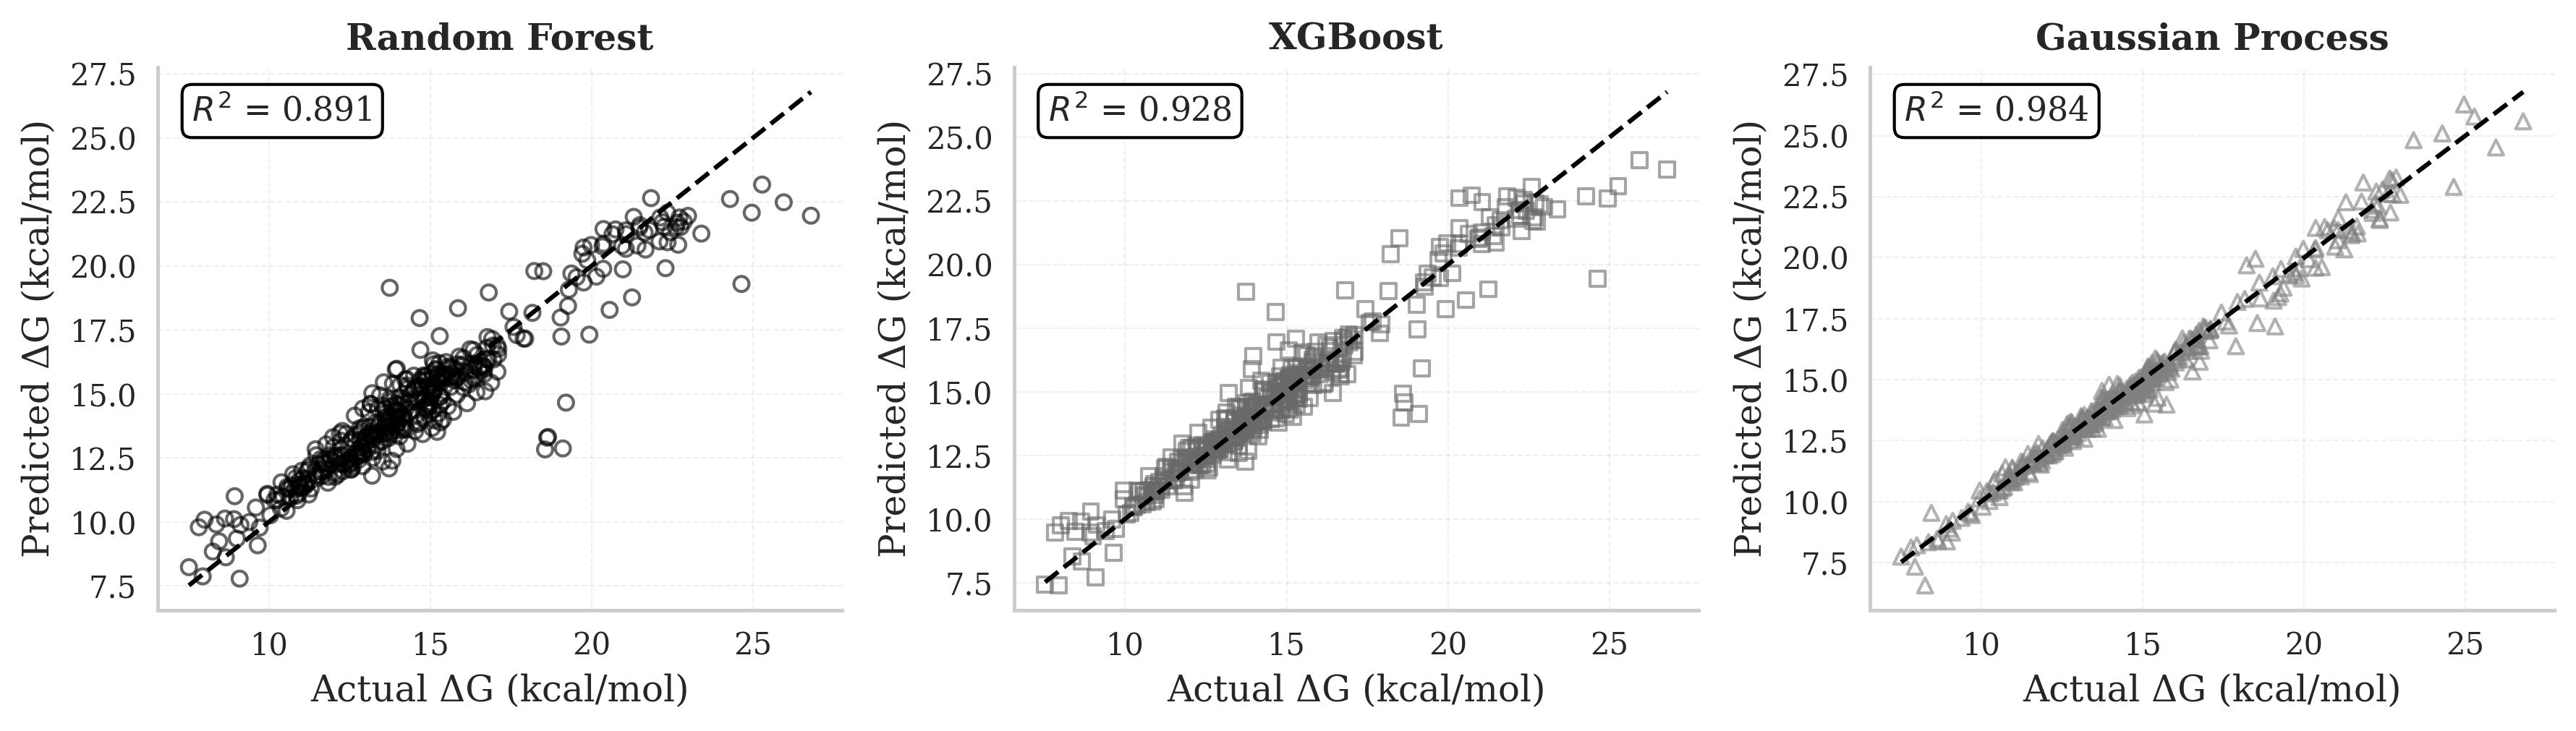

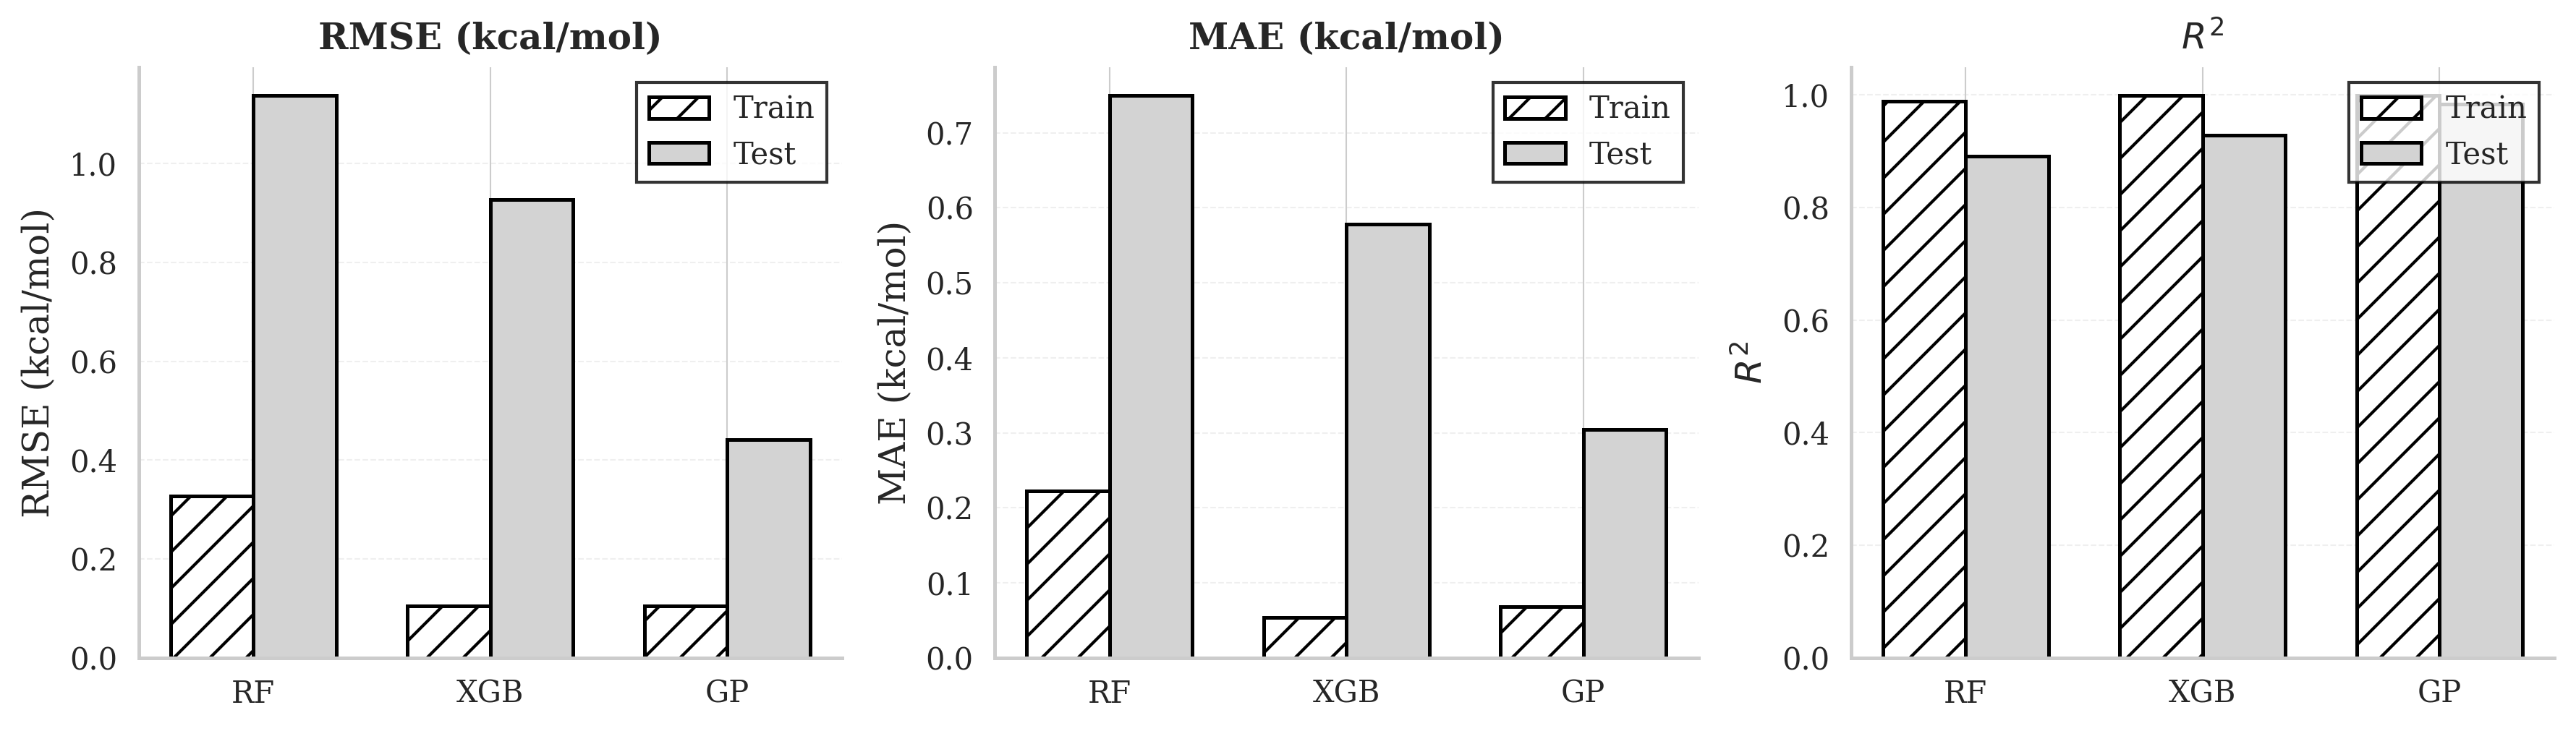


=== Train Metrics ===
      Random Forest  XGBoost  Gaussian Process
RMSE         0.3277   0.1047            0.1047
MAE          0.2229   0.0541            0.0679
R²           0.9882   0.9988            0.9988

=== Test Metrics ===
      Random Forest  XGBoost  Gaussian Process
RMSE         1.1384   0.9272            0.4414
MAE          0.7500   0.5783            0.3048
R²           0.8908   0.9276            0.9836

Calculating SHAP values for Random Forest...

Random Forest - SHAP Summary:


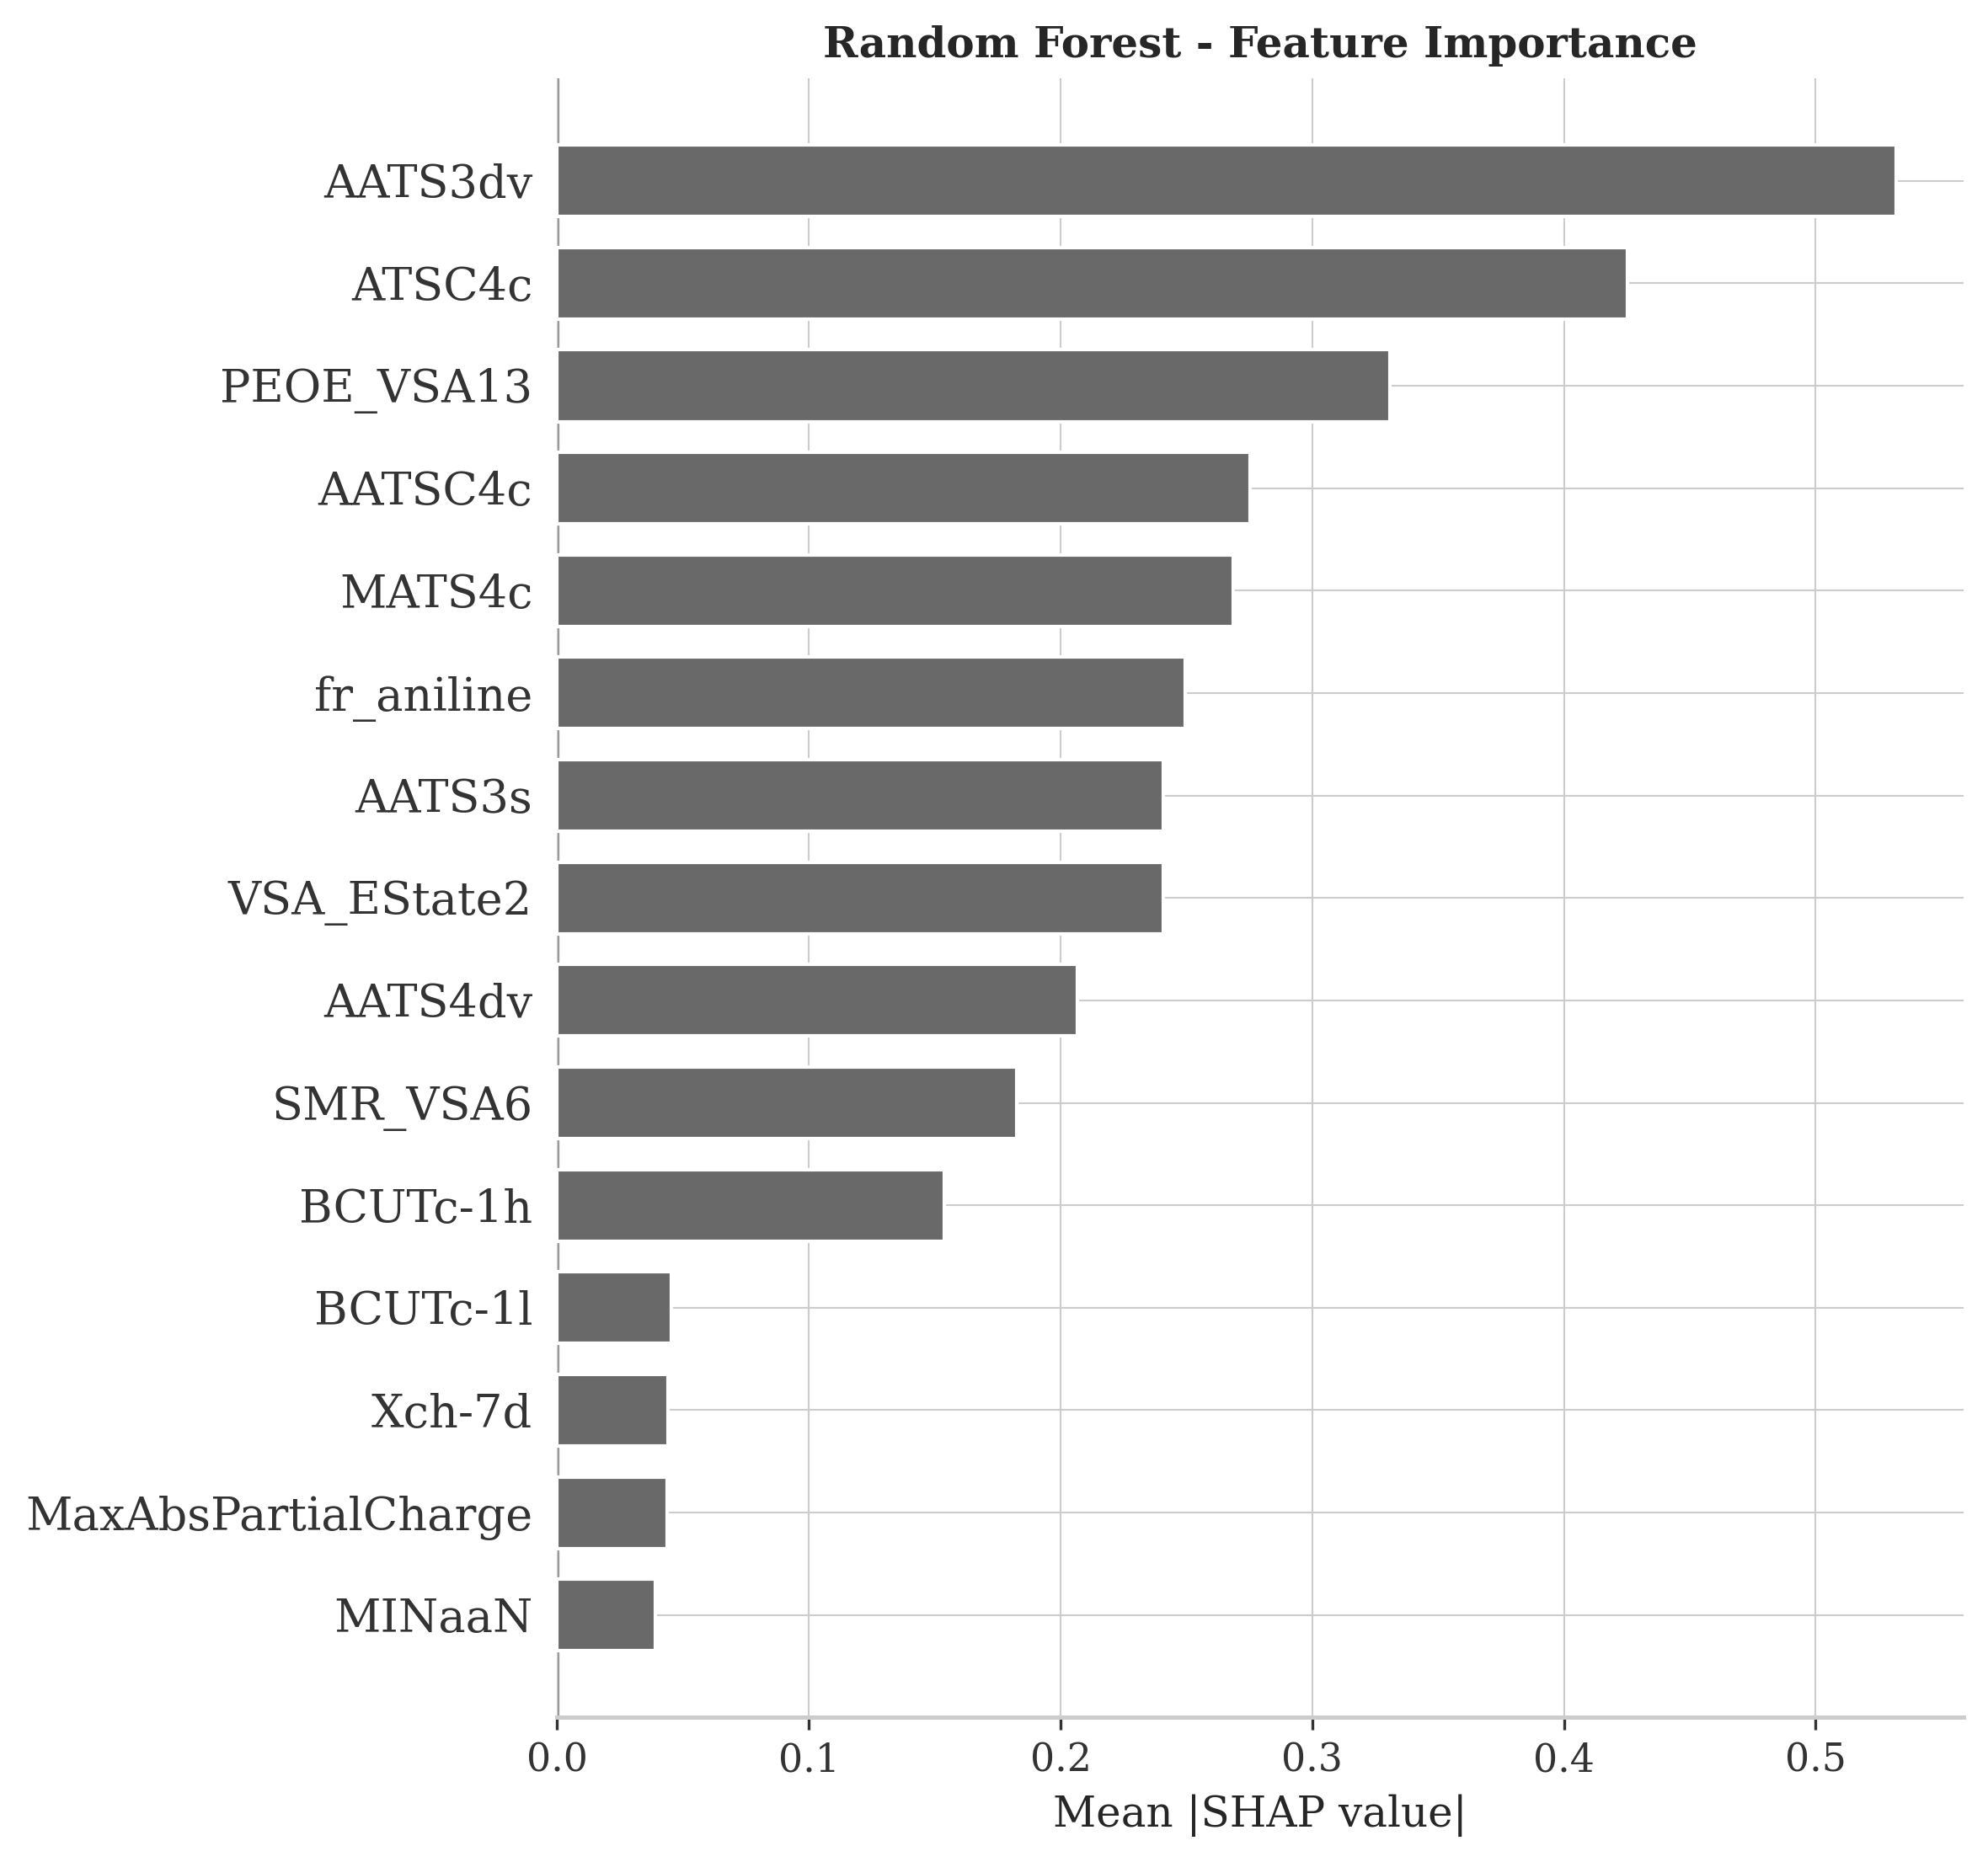


Calculating SHAP values for XGBoost...

XGBoost - SHAP Summary:


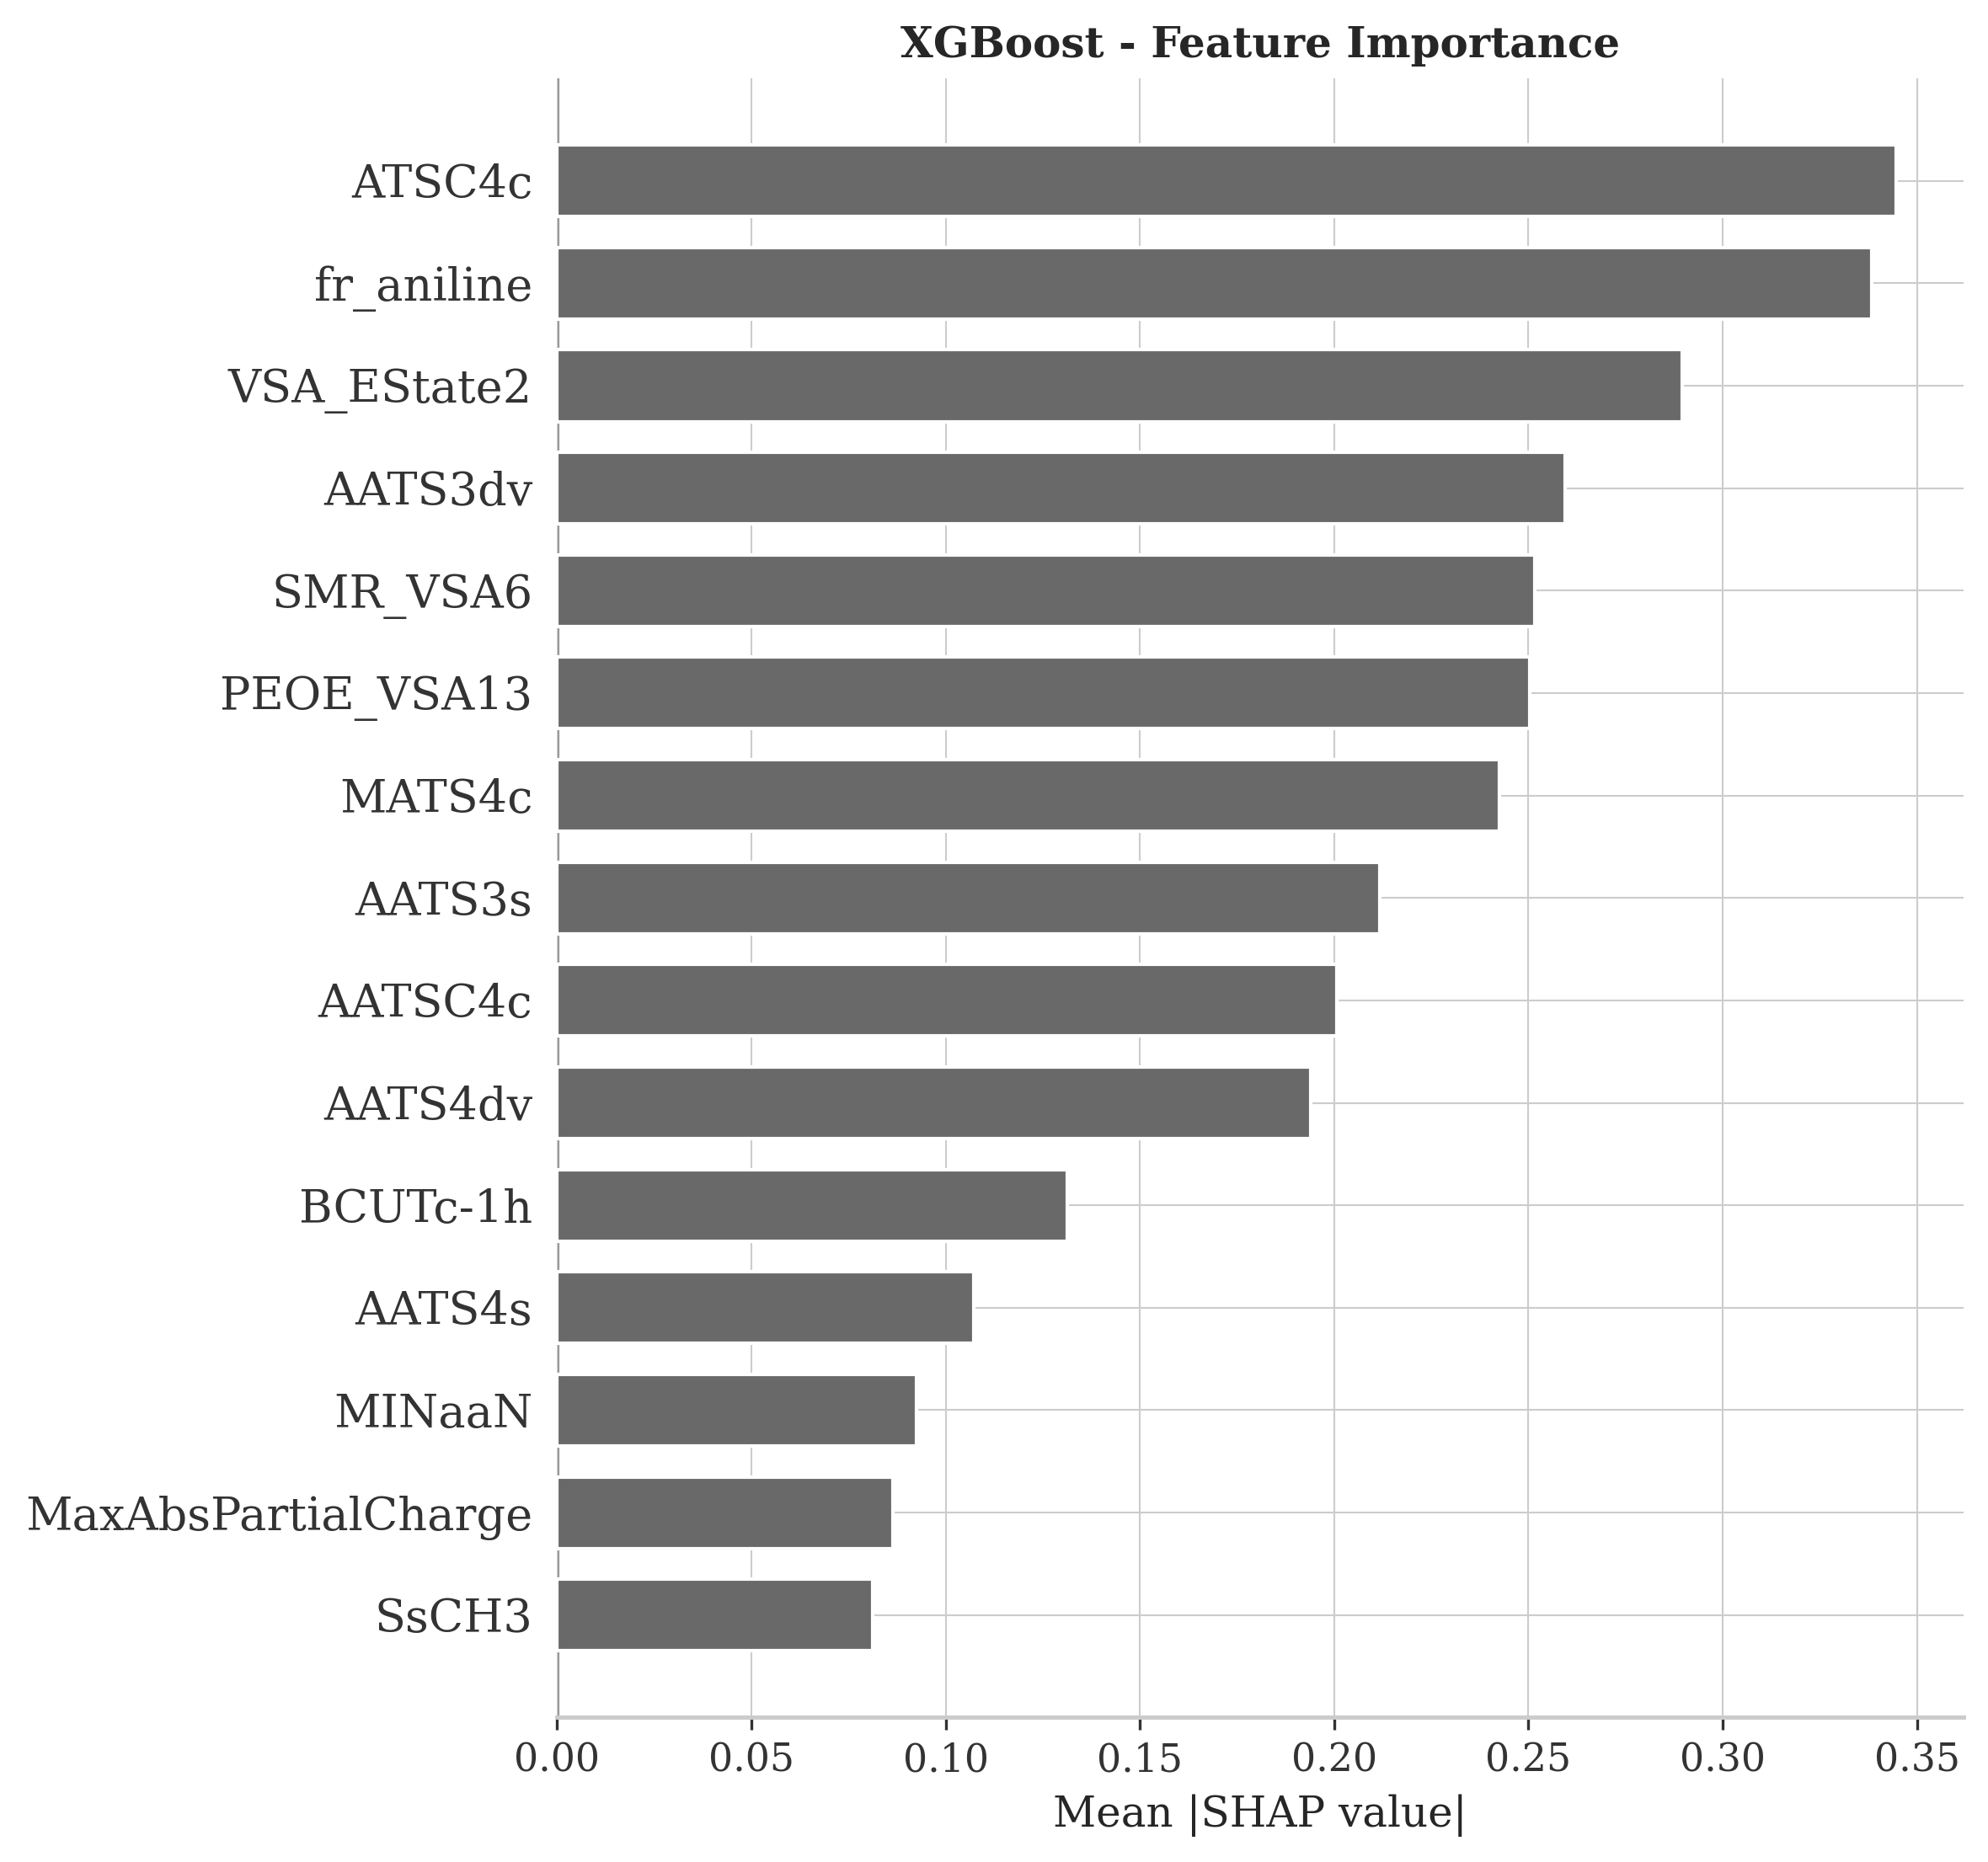


Calculating SHAP values for Gaussian Process...


  0%|          | 0/414 [00:00<?, ?it/s]


Gaussian Process - SHAP Summary:


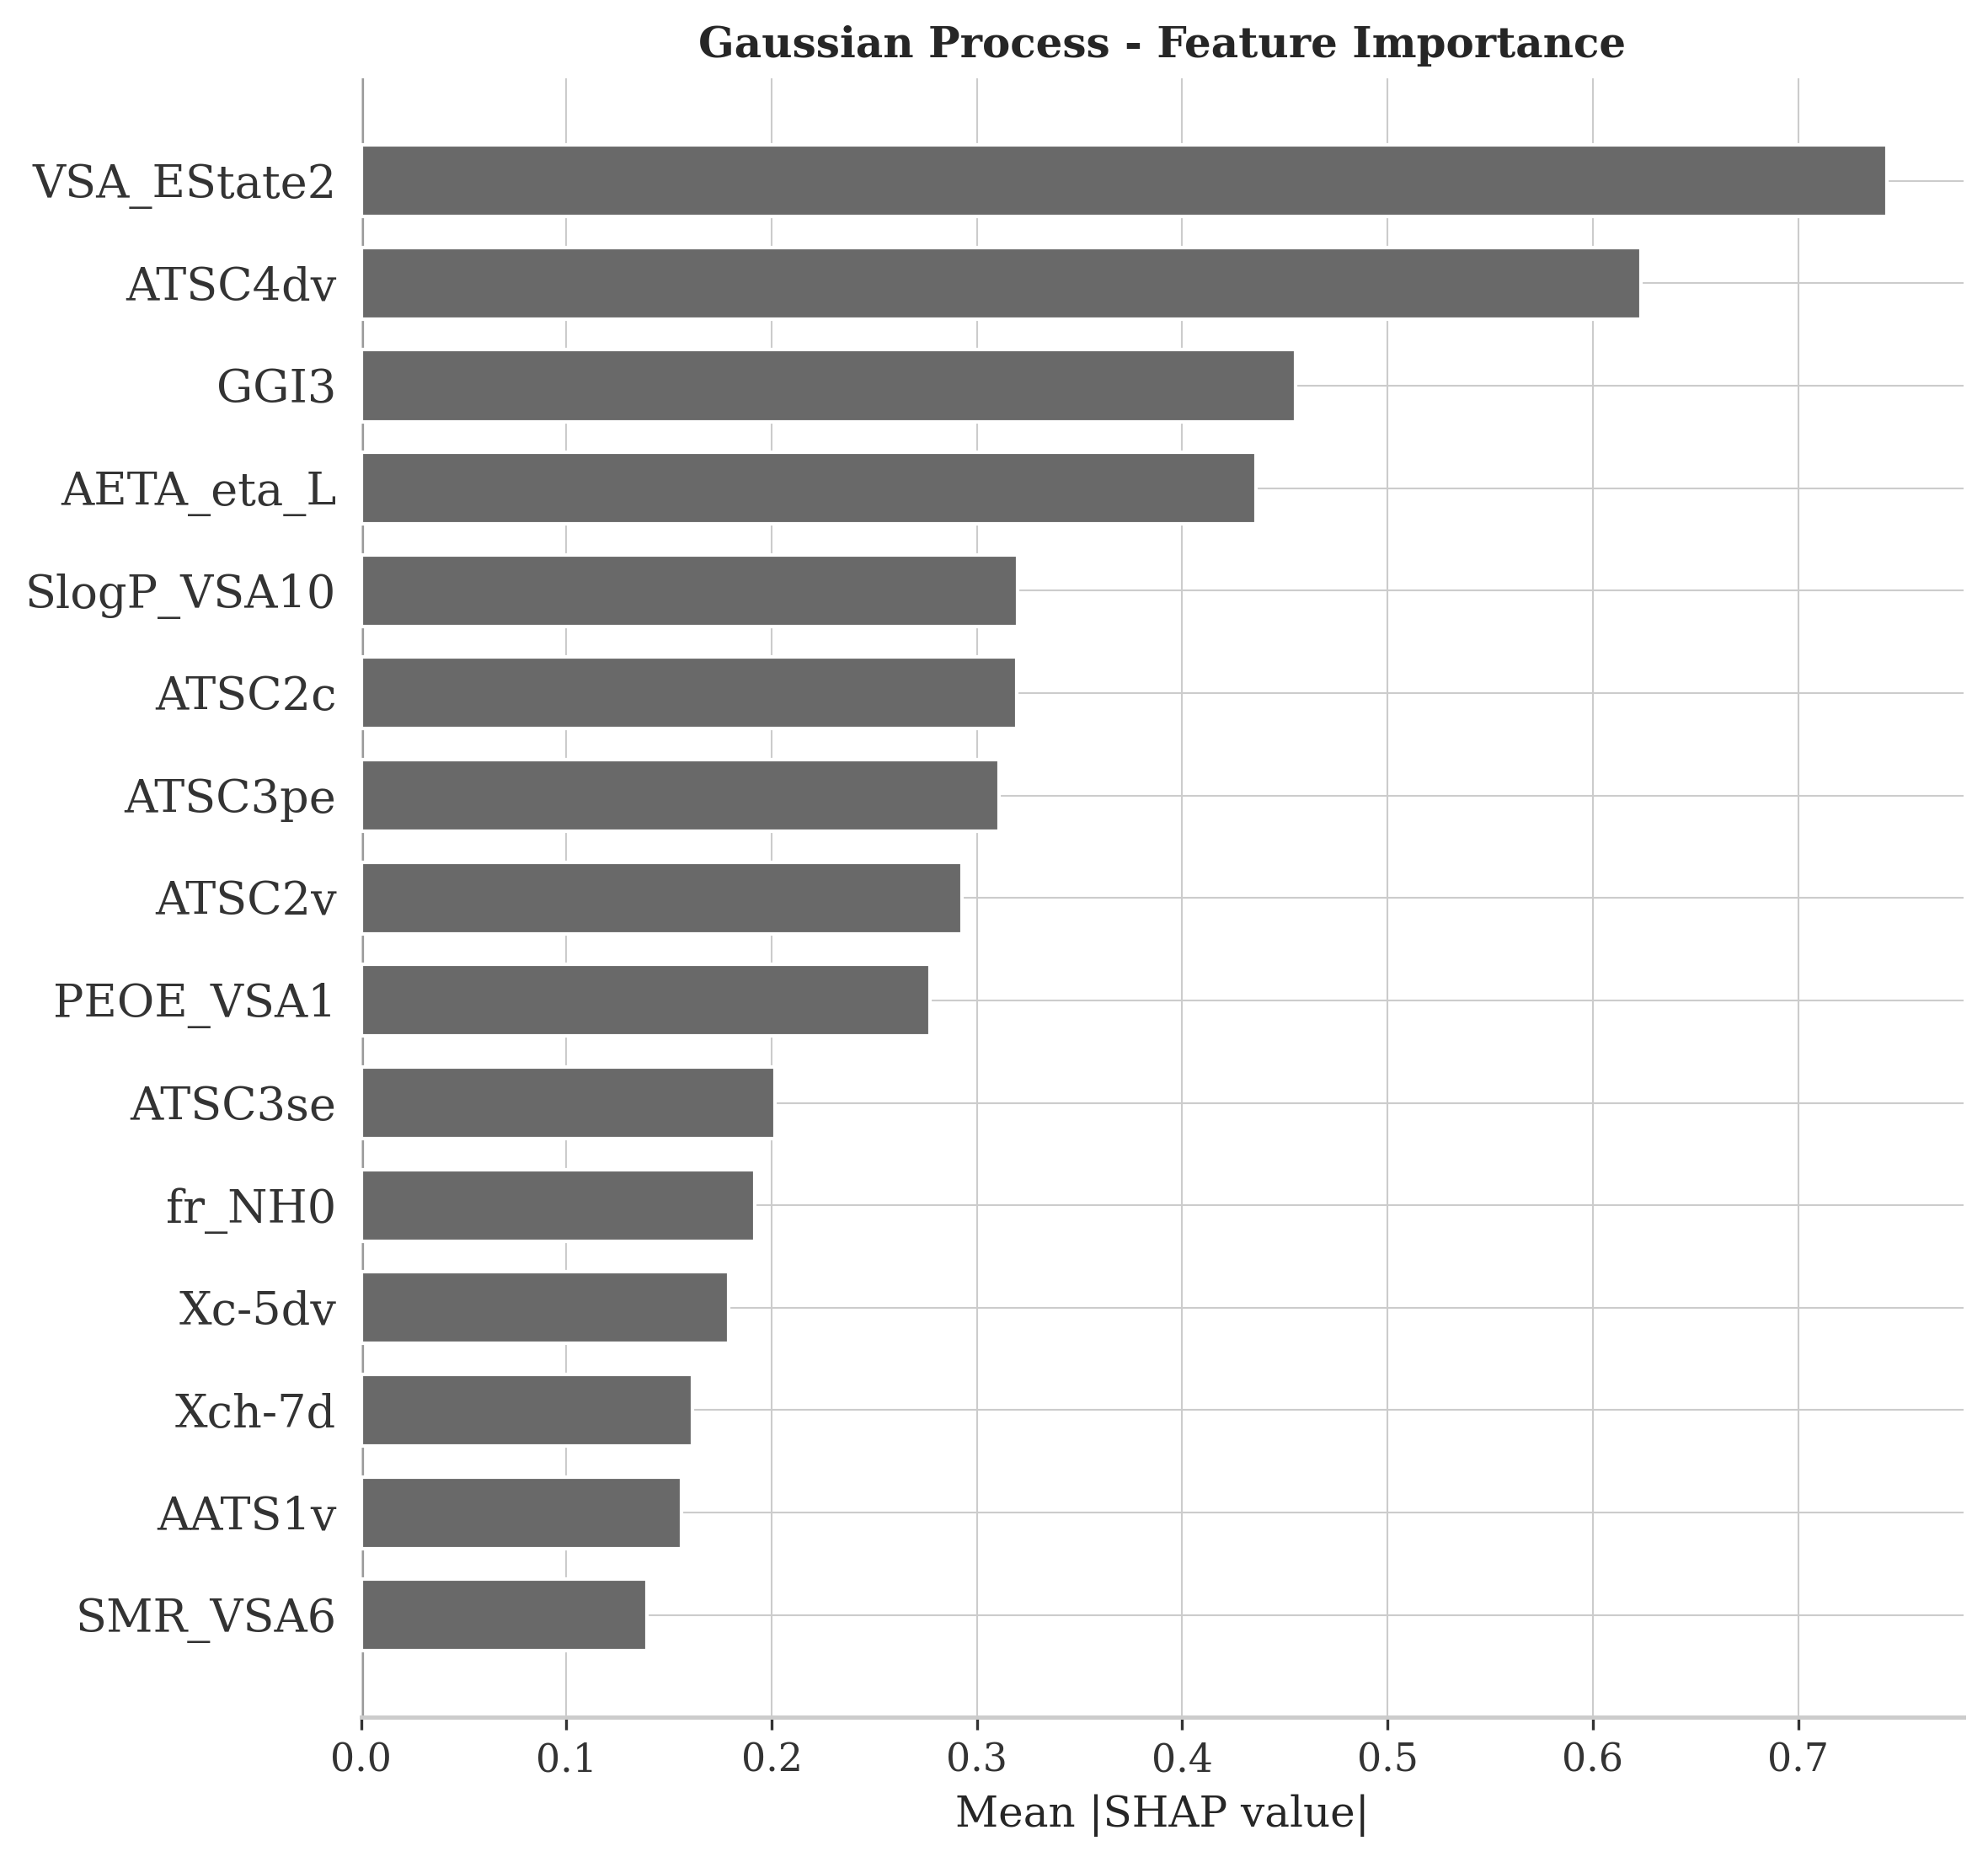

In [14]:
y_test = test_df['delta_g'].values

# Set publication-quality parameters
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
})

# Plot 1: Predictions vs Actual
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
markers = ['o', 's', '^']
colors = ['black', 'dimgray', 'gray']

for idx, (pred, name, marker, color) in enumerate(zip(
    [rf_pred, xgb_pred, gp_pred],
    ['Random Forest', 'XGBoost', 'Gaussian Process'],
    markers, colors
)):
    axes[idx].scatter(y_test, pred, alpha=0.6, s=25, marker=marker, 
                     facecolors='none', edgecolors=color, linewidths=1)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'k--', lw=1.5, label='Perfect prediction')
    axes[idx].set_xlabel('Actual ΔG (kcal/mol)', fontweight='normal')
    axes[idx].set_ylabel('Predicted ΔG (kcal/mol)', fontweight='normal')
    axes[idx].set_title(name, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    
    # Add R² annotation
    r2 = r2_score(y_test, pred)
    axes[idx].text(0.05, 0.95, f'$R^2$ = {r2:.3f}', 
                  transform=axes[idx].transAxes, 
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', 
                           edgecolor='black', linewidth=1))

plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Metrics Comparison - Train vs Test 
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

metrics_list = ['rmse', 'mae', 'r2']
titles = ['RMSE (kcal/mol)', 'MAE (kcal/mol)', '$R^2$']

for idx, (metric, title) in enumerate(zip(metrics_list, titles)):
    train_vals = [rf_train_metrics[metric], xgb_train_metrics[metric], gp_train_metrics[metric]]
    test_vals = [rf_test_metrics[metric], xgb_test_metrics[metric], gp_test_metrics[metric]]
    
    x = np.arange(3)
    width = 0.35
    
    # Black and white with hatching patterns
    axes[idx].bar(x - width/2, train_vals, width, label='Train', 
                 color='white', edgecolor='black', linewidth=1.2, hatch='//')
    axes[idx].bar(x + width/2, test_vals, width, label='Test', 
                 color='lightgray', edgecolor='black', linewidth=1.2)
    
    axes[idx].set_ylabel(title, fontweight='normal')
    axes[idx].set_title(title, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(['RF', 'XGB', 'GP'])
    axes[idx].legend(frameon=True, edgecolor='black', fancybox=False)
    axes[idx].grid(True, alpha=0.3, linestyle='--', axis='y')
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print metrics summary
print("\n=== Train Metrics ===")
train_df_metrics = pd.DataFrame({
    'Random Forest': [rf_train_metrics['rmse'], rf_train_metrics['mae'], rf_train_metrics['r2']],
    'XGBoost': [xgb_train_metrics['rmse'], xgb_train_metrics['mae'], xgb_train_metrics['r2']],
    'Gaussian Process': [gp_train_metrics['rmse'], gp_train_metrics['mae'], gp_train_metrics['r2']]
}, index=['RMSE', 'MAE', 'R²'])
print(train_df_metrics.round(4))

print("\n=== Test Metrics ===")
test_df_metrics = pd.DataFrame({
    'Random Forest': [rf_test_metrics['rmse'], rf_test_metrics['mae'], rf_test_metrics['r2']],
    'XGBoost': [xgb_test_metrics['rmse'], xgb_test_metrics['mae'], xgb_test_metrics['r2']],
    'Gaussian Process': [gp_test_metrics['rmse'], gp_test_metrics['mae'], gp_test_metrics['r2']]
}, index=['RMSE', 'MAE', 'R²'])
print(test_df_metrics.round(4))


# SHAP Analysis
def calculate_shap_values(model, X_test, model_name):
    """
    Calculate and plot SHAP values for a model.
    
    Args:
        model: Trained model
        X_test: Test features
        model_name: Name of the model
    """
    if model_name in ['Random Forest', 'XGBoost']:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
    else:  # Gaussian Process
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_test, 100))
        shap_values = explainer.shap_values(X_test)
    
    print(f"\n{model_name} - SHAP Summary:")
    
    # Publication-quality SHAP plot
    plt.figure(figsize=(8, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, 
                     color='dimgray', max_display=15)
    plt.xlabel('Mean |SHAP value|', fontsize=12, fontweight='normal')
    plt.title(f'{model_name} - Feature Importance', fontsize=12, fontweight='bold')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    
    # Save with model name
    filename = f'shap_{model_name.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return shap_values


X_test = test_df.drop(columns=['delta_g'])

print("\nCalculating SHAP values for Random Forest...")
rf_shap = calculate_shap_values(rf_model, X_test, 'Random Forest')

print("\nCalculating SHAP values for XGBoost...")
xgb_shap = calculate_shap_values(xgb_model, X_test, 'XGBoost')

print("\nCalculating SHAP values for Gaussian Process...")
gp_shap = calculate_shap_values(gp_model, X_test, 'Gaussian Process')


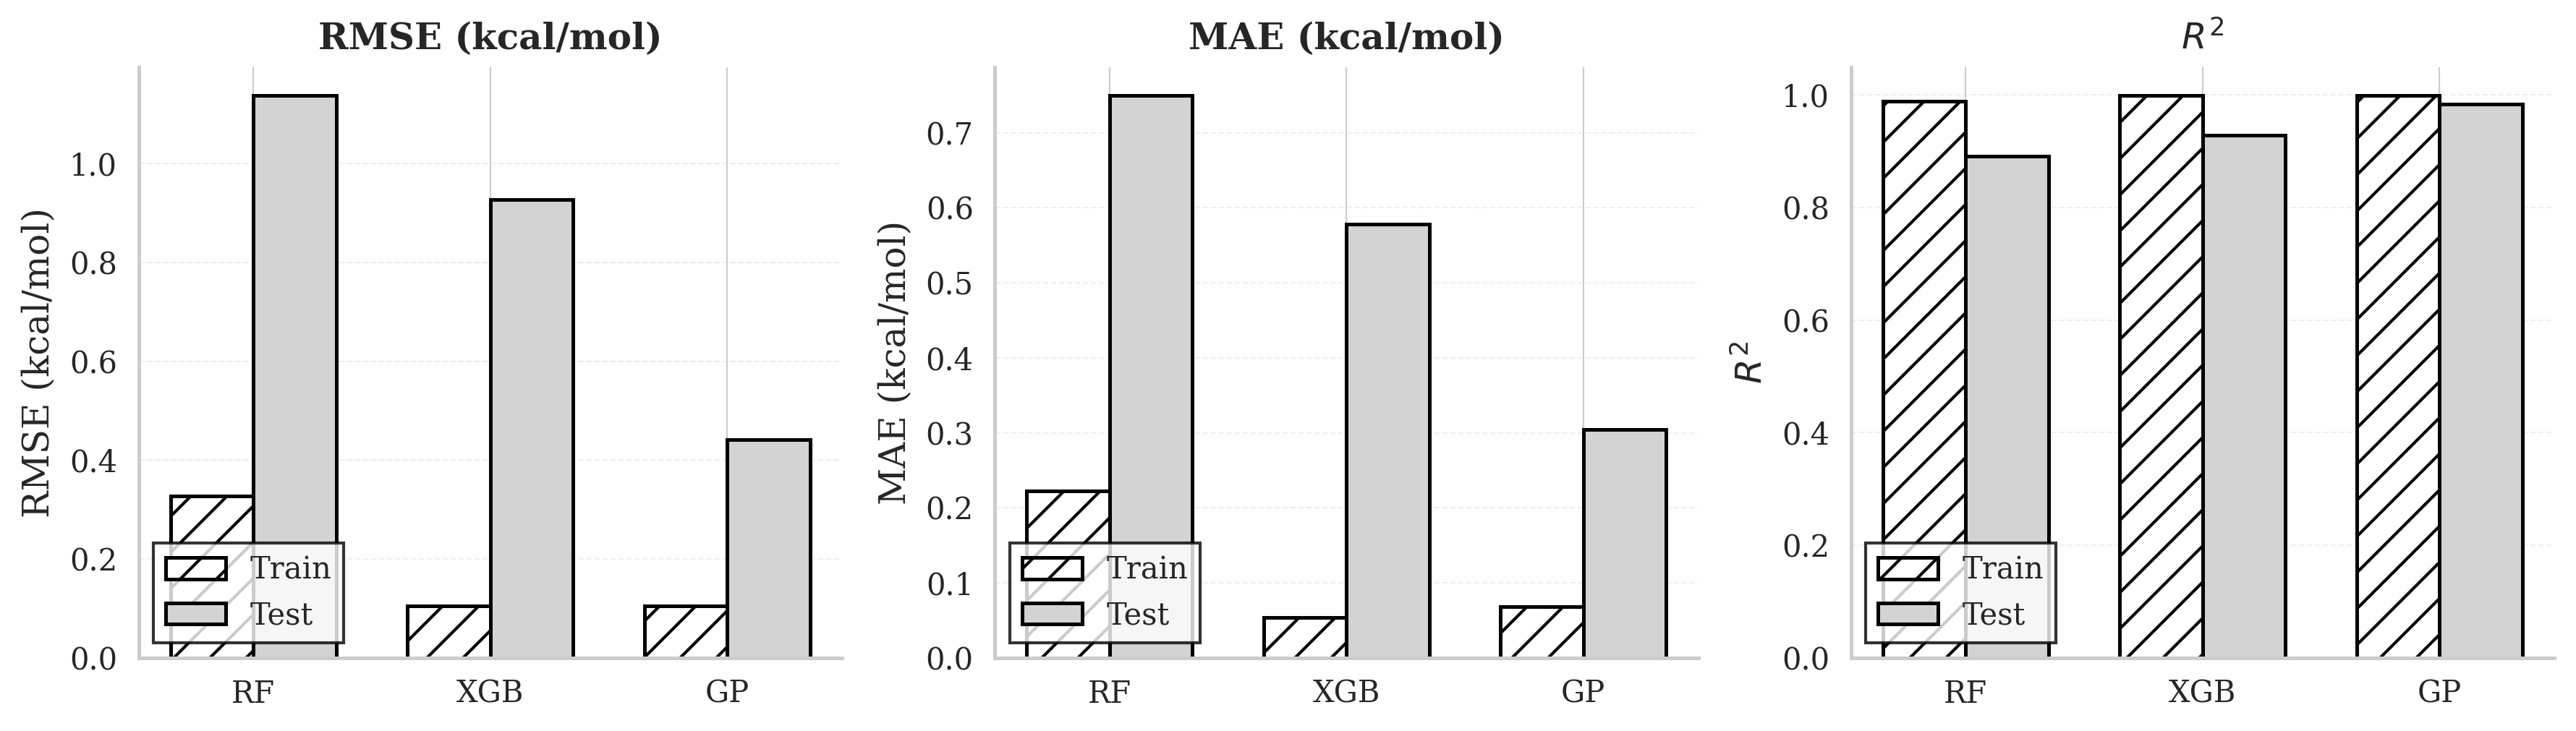

In [17]:
# Fix legend overlap in metrics comparison plot
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

metrics_list = ['rmse', 'mae', 'r2']
titles = ['RMSE (kcal/mol)', 'MAE (kcal/mol)', '$R^2$']

for idx, (metric, title) in enumerate(zip(metrics_list, titles)):
    train_vals = [rf_train_metrics[metric], xgb_train_metrics[metric], gp_train_metrics[metric]]
    test_vals = [rf_test_metrics[metric], xgb_test_metrics[metric], gp_test_metrics[metric]]
    
    x = np.arange(3)
    width = 0.35
    
    axes[idx].bar(x - width/2, train_vals, width, label='Train', 
                 color='white', edgecolor='black', linewidth=1.2, hatch='//')
    axes[idx].bar(x + width/2, test_vals, width, label='Test', 
                 color='lightgray', edgecolor='black', linewidth=1.2)
    
    axes[idx].set_ylabel(title, fontweight='normal')
    axes[idx].set_title(title, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(['RF', 'XGB', 'GP'])
    
    # Consistent legend position for all plots (lower left avoids overlap)
    axes[idx].legend(frameon=True, edgecolor='black', fancybox=False, loc='lower left')
    
    axes[idx].grid(True, alpha=0.3, linestyle='--', axis='y')
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('metrics_comparison_fixed.png', dpi=300, bbox_inches='tight')
plt.show()


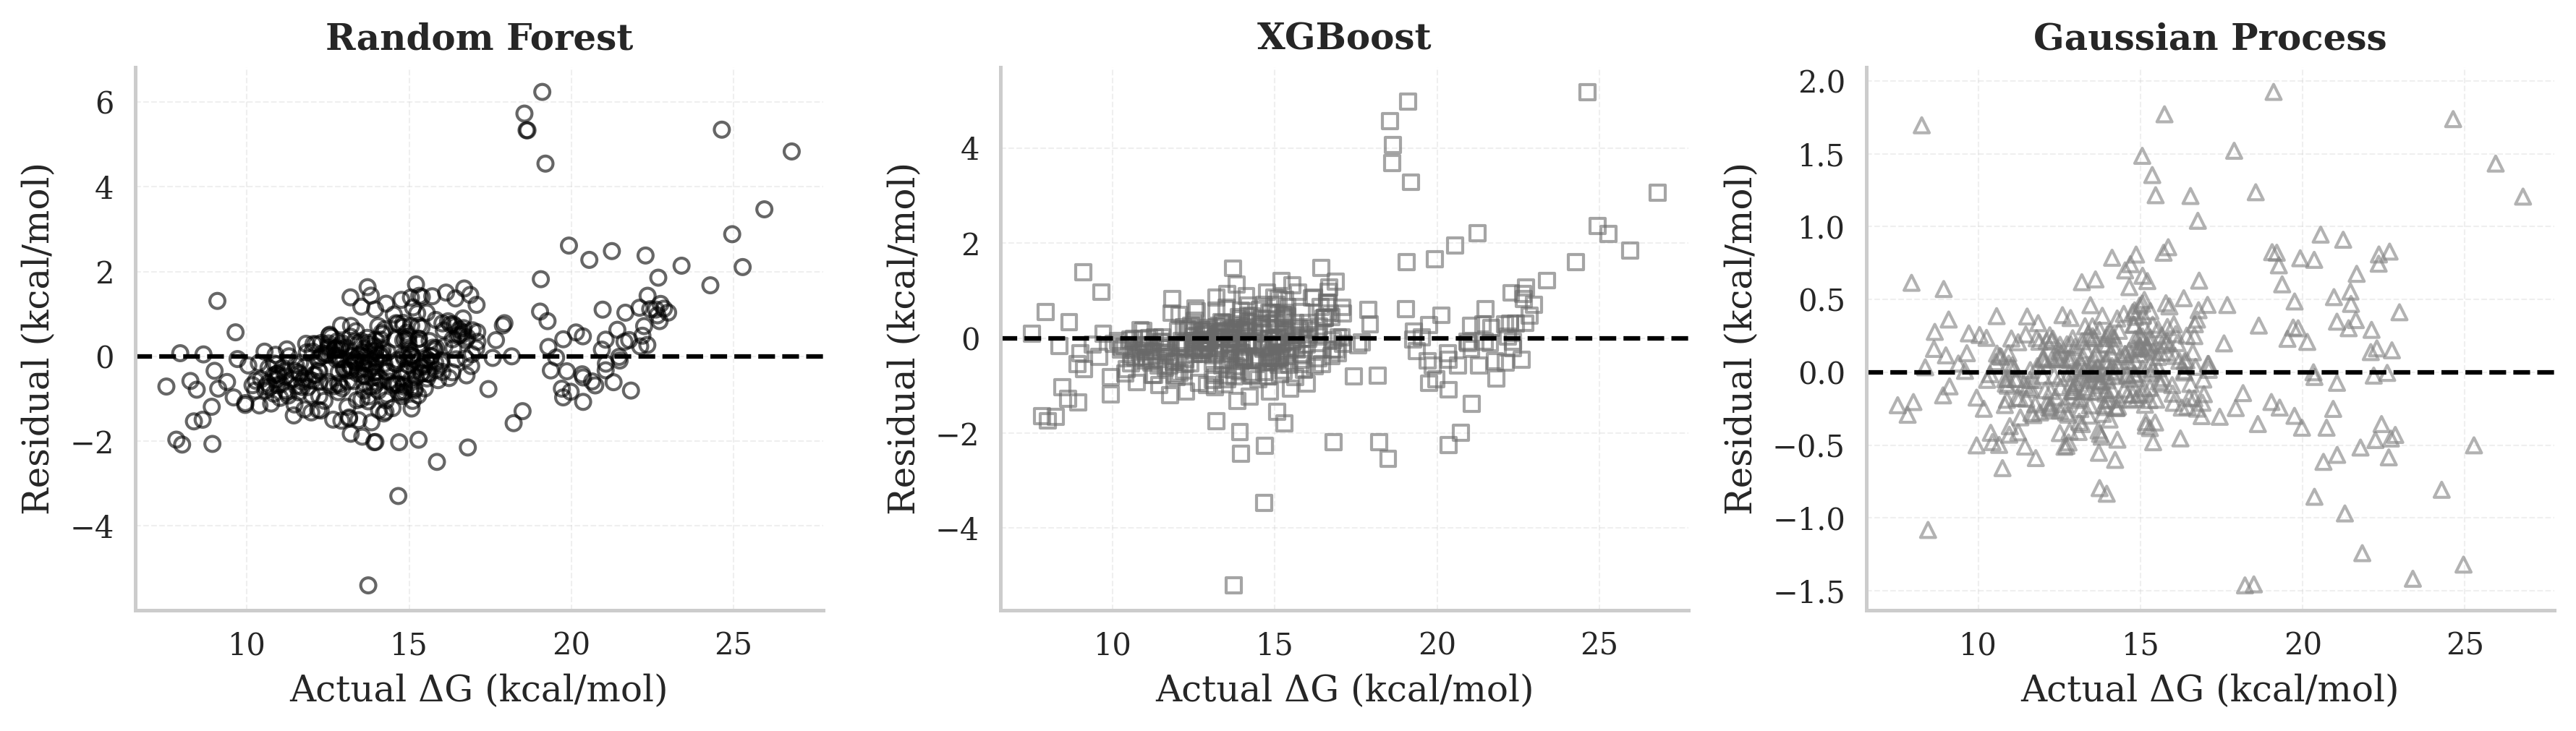

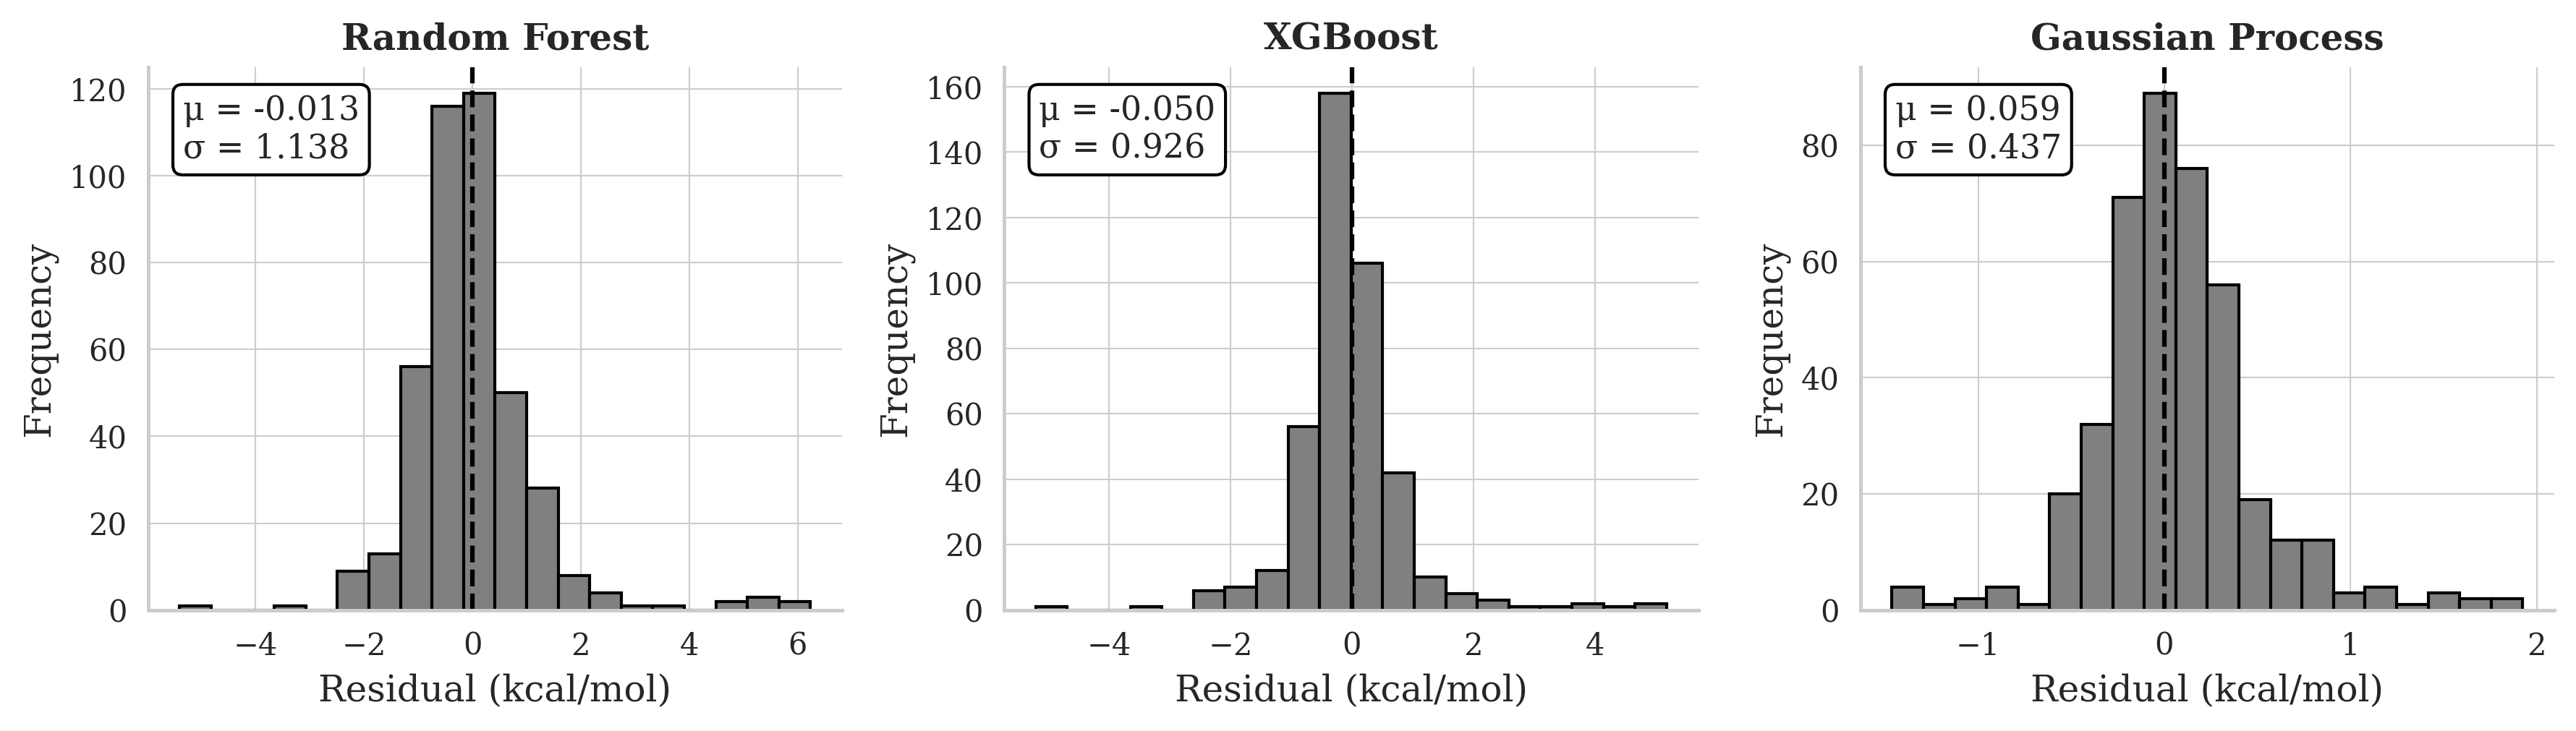

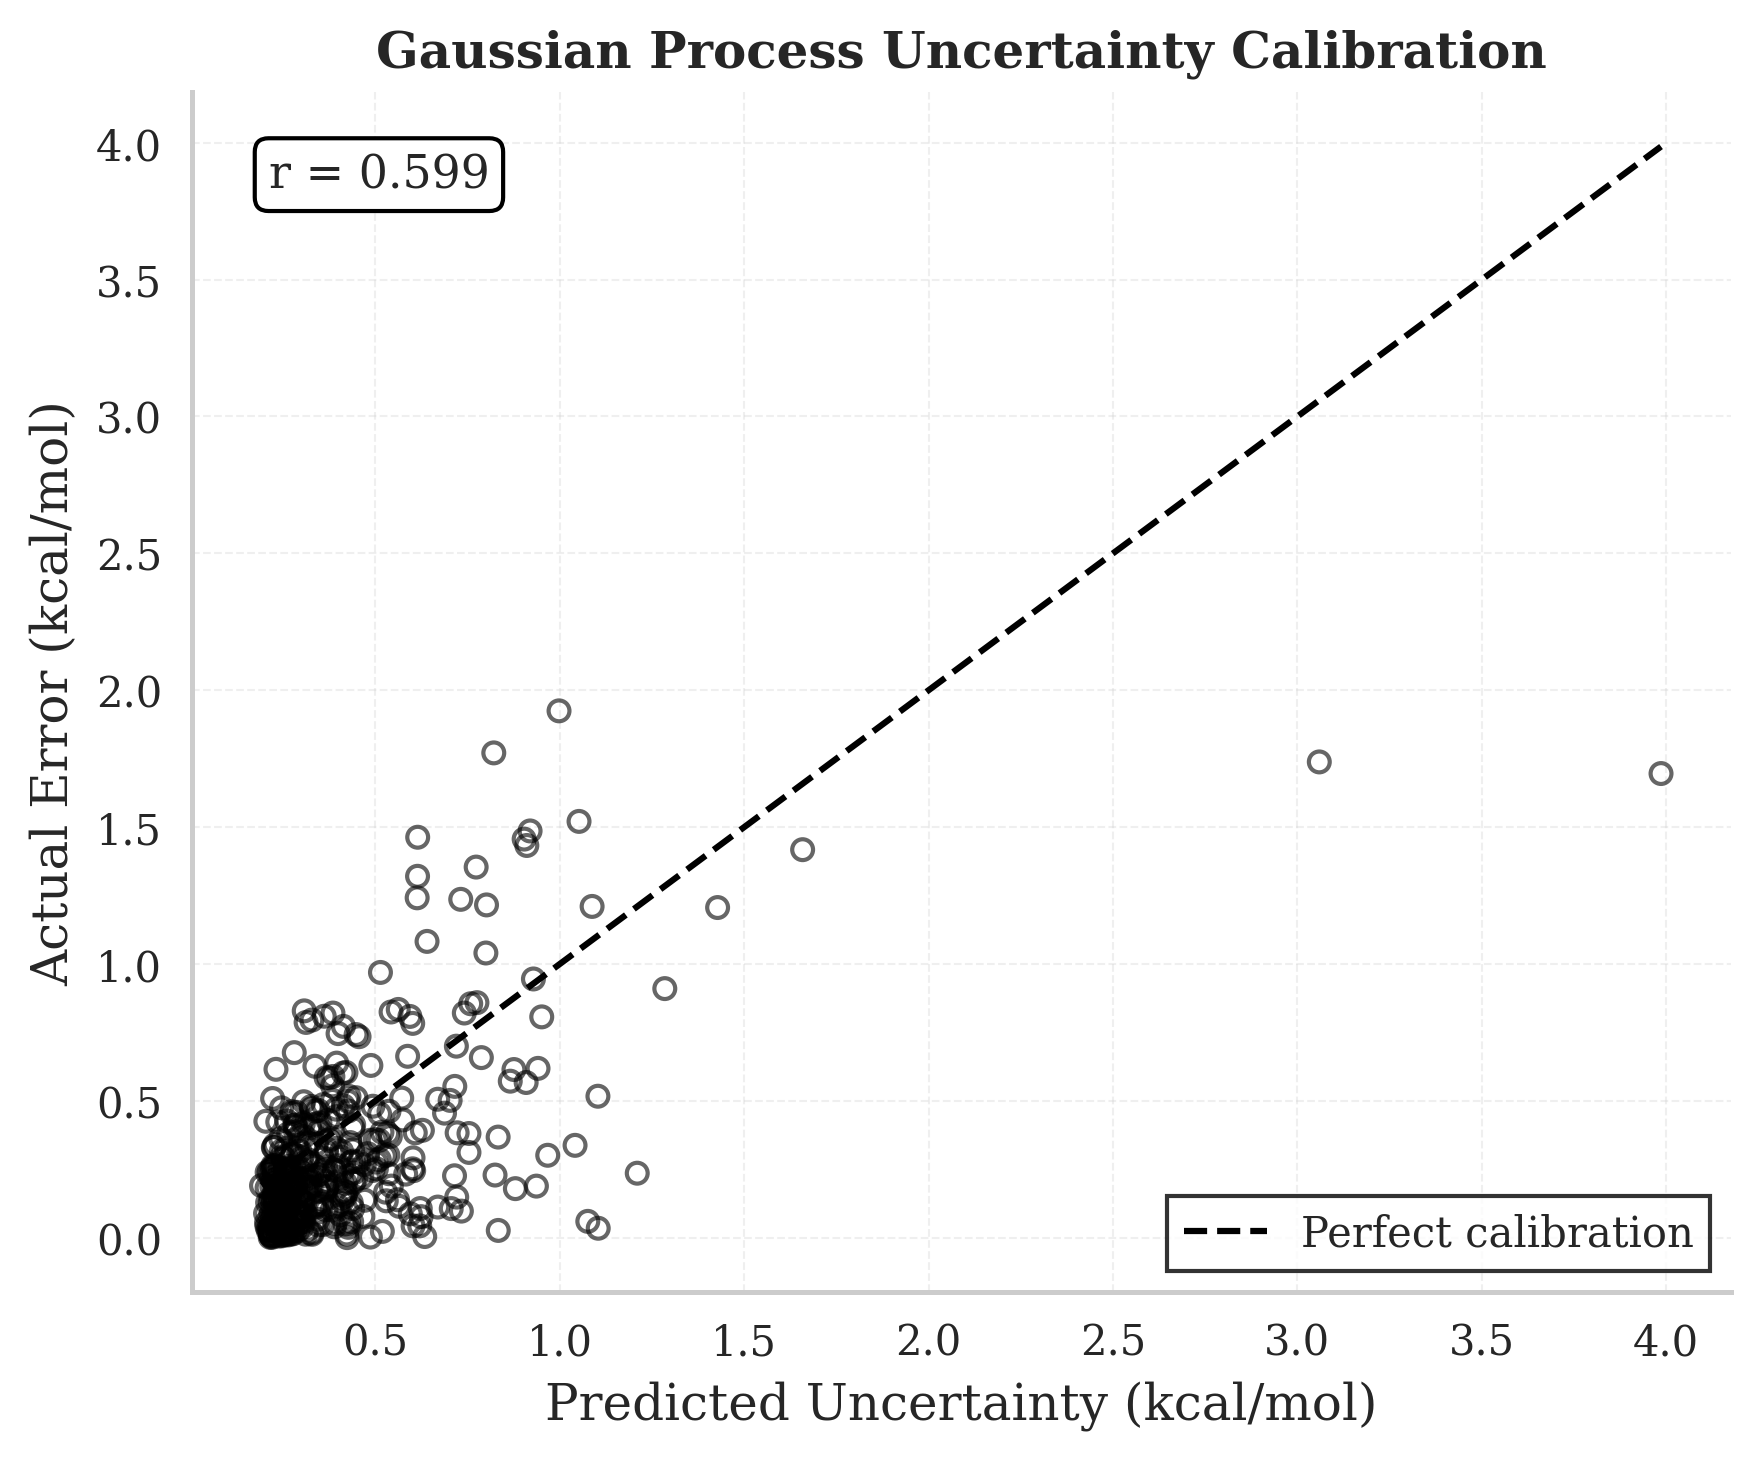

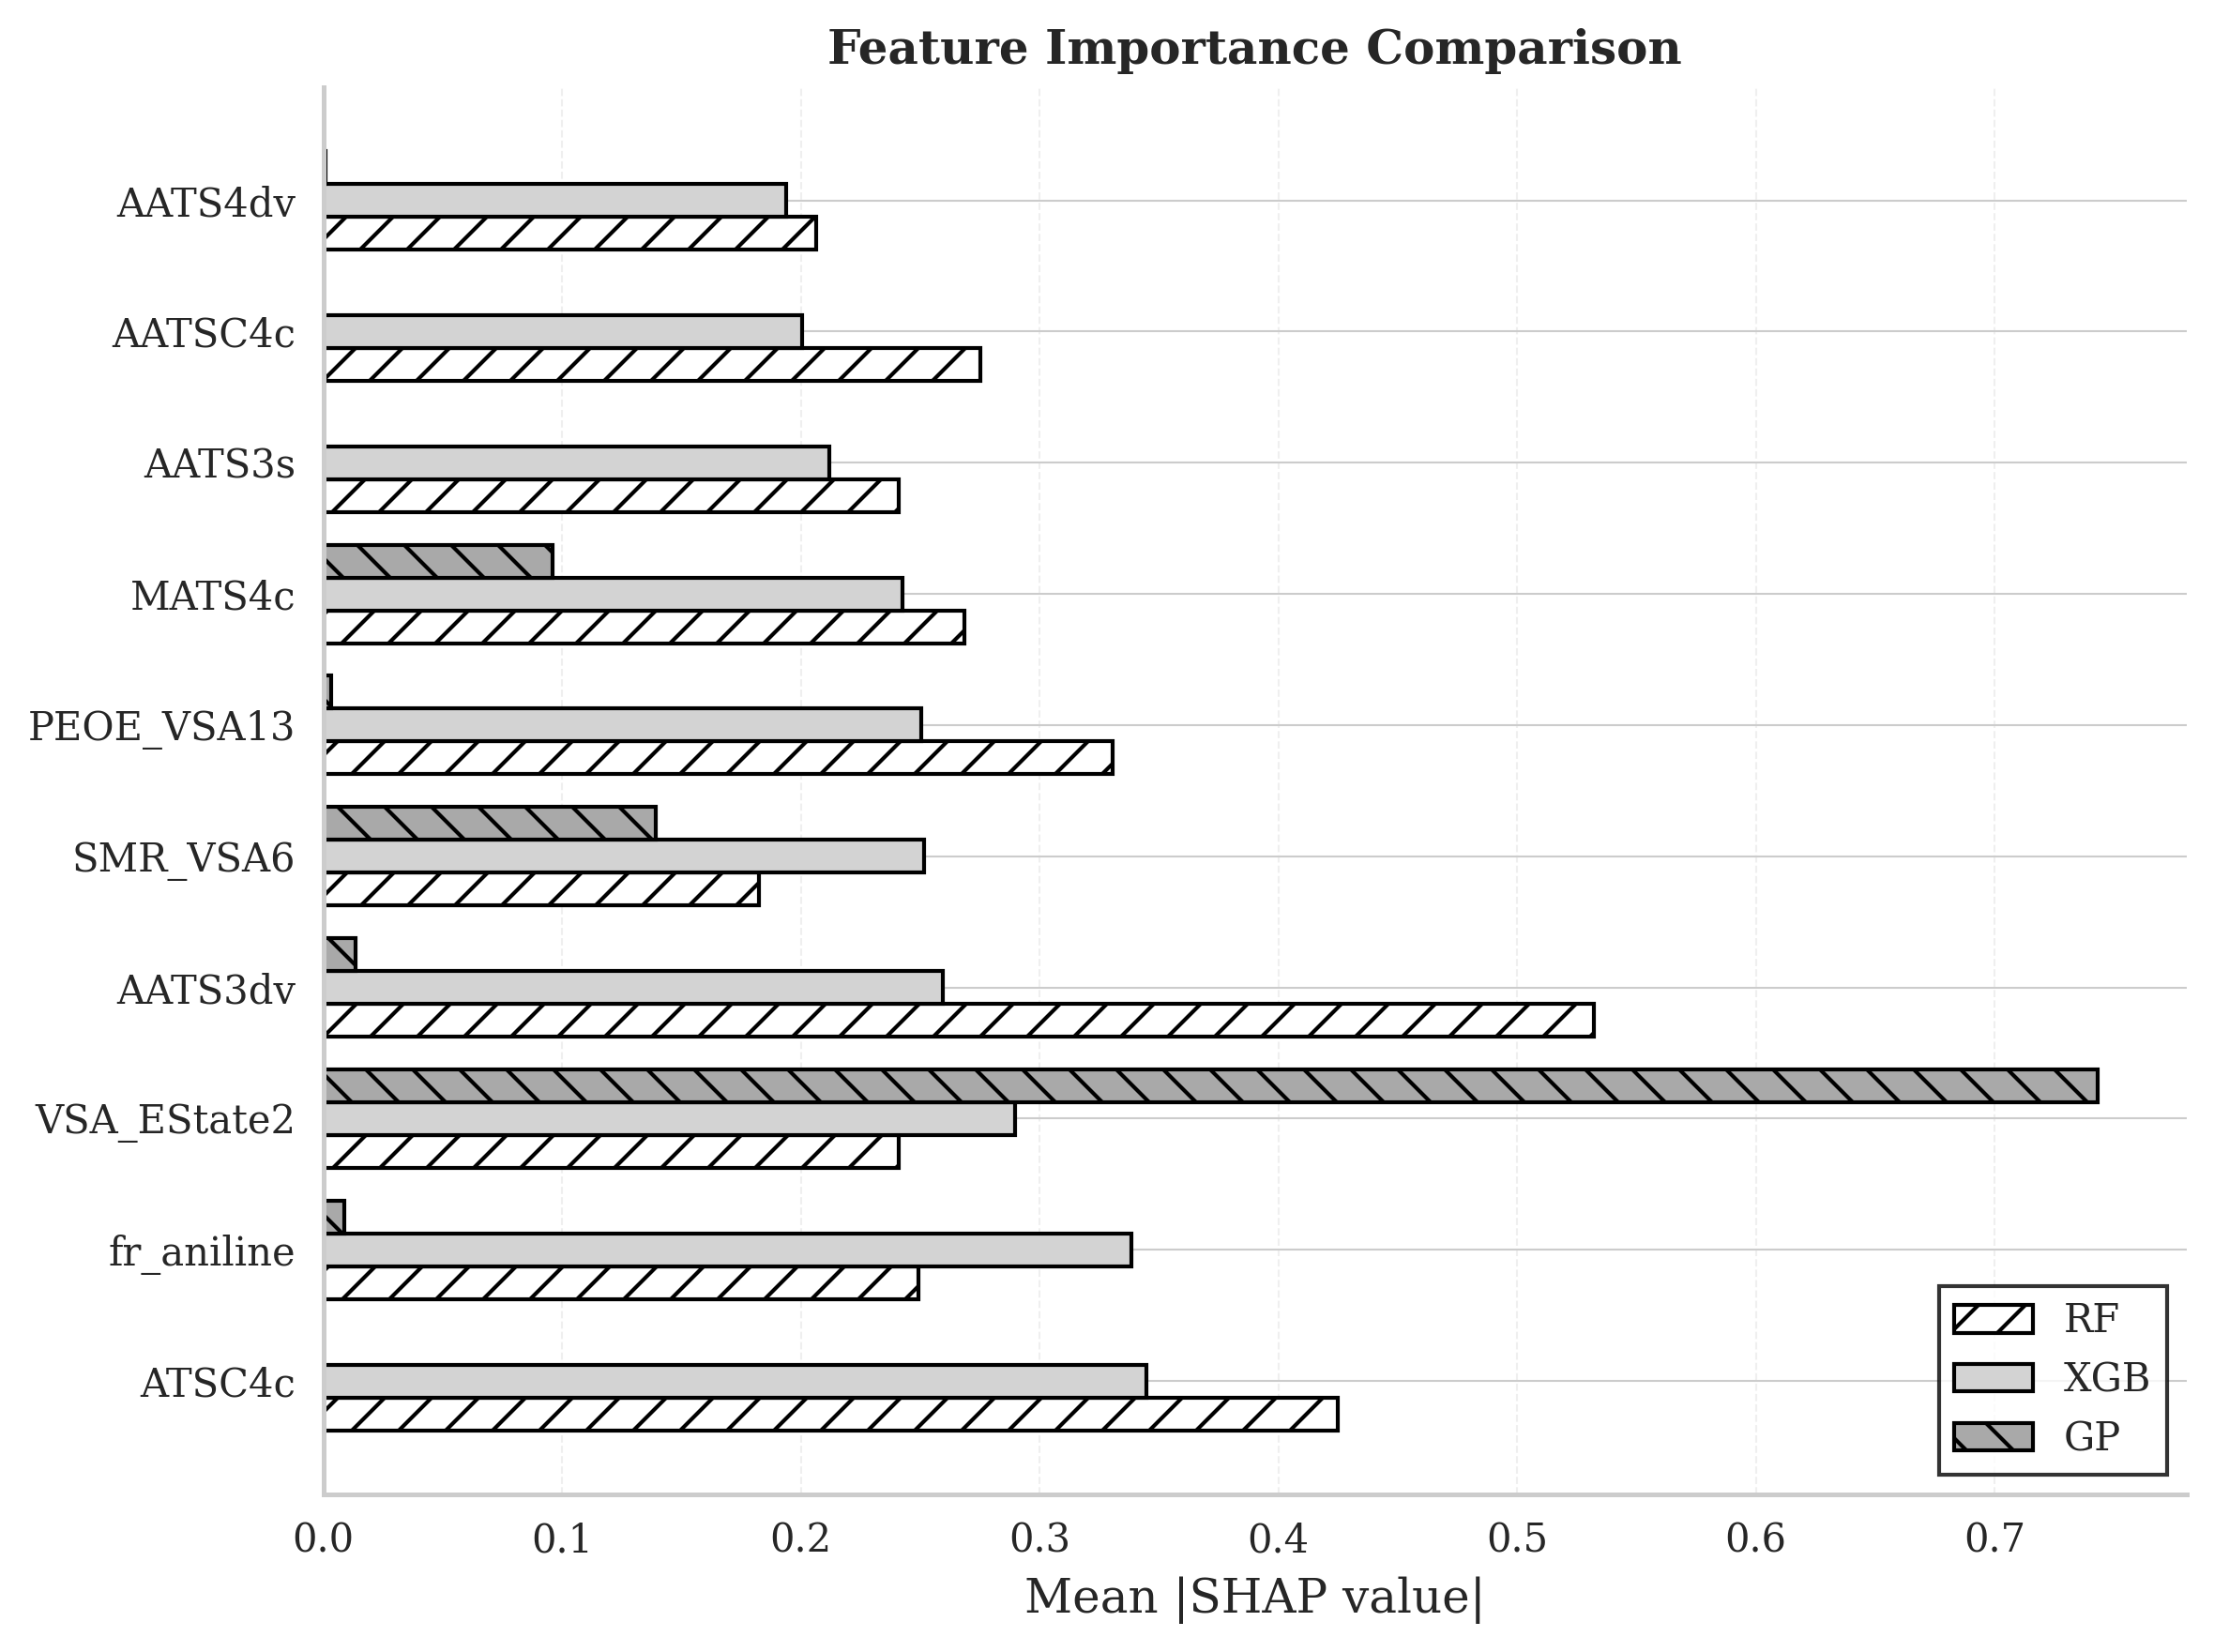


All additional plots saved!


In [18]:
# Additional Publication-Quality Plots

# 1. Residual Plots - Check for systematic bias
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
markers = ['o', 's', '^']
colors = ['black', 'dimgray', 'gray']

for idx, (pred, name, marker, color) in enumerate(zip(
    [rf_pred, xgb_pred, gp_pred],
    ['Random Forest', 'XGBoost', 'Gaussian Process'],
    markers, colors
)):
    residuals = y_test - pred
    axes[idx].scatter(y_test, residuals, alpha=0.6, s=25, marker=marker,
                     facecolors='none', edgecolors=color, linewidths=1)
    axes[idx].axhline(y=0, color='k', linestyle='--', lw=1.5)
    axes[idx].set_xlabel('Actual ΔG (kcal/mol)', fontweight='normal')
    axes[idx].set_ylabel('Residual (kcal/mol)', fontweight='normal')
    axes[idx].set_title(name, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('residual_plots.png', dpi=300, bbox_inches='tight')
plt.show()


# 2. Error Distribution - Check for normality
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

for idx, (pred, name) in enumerate(zip(
    [rf_pred, xgb_pred, gp_pred],
    ['Random Forest', 'XGBoost', 'Gaussian Process']
)):
    residuals = y_test - pred
    axes[idx].hist(residuals, bins=20, color='gray', edgecolor='black', linewidth=1)
    axes[idx].axvline(x=0, color='k', linestyle='--', lw=1.5)
    axes[idx].set_xlabel('Residual (kcal/mol)', fontweight='normal')
    axes[idx].set_ylabel('Frequency', fontweight='normal')
    axes[idx].set_title(name, fontweight='bold')
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    
    # Add mean and std annotation
    axes[idx].text(0.05, 0.95, f'μ = {residuals.mean():.3f}\nσ = {residuals.std():.3f}',
                  transform=axes[idx].transAxes, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', linewidth=1))

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


# 3. Gaussian Process Uncertainty Calibration
fig, ax = plt.subplots(figsize=(6, 5))
residuals_abs = np.abs(y_test - gp_pred)
ax.scatter(gp_std, residuals_abs, alpha=0.6, s=25, marker='o',
          facecolors='none', edgecolors='black', linewidths=1)
ax.plot([gp_std.min(), gp_std.max()], [gp_std.min(), gp_std.max()], 
        'k--', lw=1.5, label='Perfect calibration')
ax.set_xlabel('Predicted Uncertainty (kcal/mol)', fontweight='normal')
ax.set_ylabel('Actual Error (kcal/mol)', fontweight='normal')
ax.set_title('Gaussian Process Uncertainty Calibration', fontweight='bold')
ax.legend(frameon=True, edgecolor='black', fancybox=False)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add correlation annotation
from scipy.stats import pearsonr
corr, _ = pearsonr(gp_std, residuals_abs)
ax.text(0.05, 0.95, f'r = {corr:.3f}',
       transform=ax.transAxes, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', linewidth=1))

plt.tight_layout()
plt.savefig('gp_uncertainty_calibration.png', dpi=300, bbox_inches='tight')
plt.show()


# 4. Top Feature Importance Comparison Across Models
top_n = 10

# Get top features from each model
rf_feature_importance = np.abs(rf_shap).mean(axis=0)
xgb_feature_importance = np.abs(xgb_shap).mean(axis=0)
gp_feature_importance = np.abs(gp_shap).mean(axis=0)

# Get top features from XGBoost (usually the best)
top_features_idx = np.argsort(xgb_feature_importance)[-top_n:][::-1]
top_features = X_test.columns[top_features_idx]

# Create comparison dataframe
importance_comparison = pd.DataFrame({
    'RF': rf_feature_importance[top_features_idx],
    'XGB': xgb_feature_importance[top_features_idx],
    'GP': gp_feature_importance[top_features_idx]
}, index=top_features)

fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(top_features))
width = 0.25

ax.barh(x - width, importance_comparison['RF'], width, label='RF',
       color='white', edgecolor='black', linewidth=1, hatch='//')
ax.barh(x, importance_comparison['XGB'], width, label='XGB',
       color='lightgray', edgecolor='black', linewidth=1)
ax.barh(x + width, importance_comparison['GP'], width, label='GP',
       color='darkgray', edgecolor='black', linewidth=1, hatch='\\\\')

ax.set_yticks(x)
ax.set_yticklabels(top_features)
ax.set_xlabel('Mean |SHAP value|', fontweight='normal')
ax.set_title('Feature Importance Comparison', fontweight='bold')
ax.legend(frameon=True, edgecolor='black', fancybox=False, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linestyle='--', axis='x')

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAll additional plots saved!")
